In [1]:
import anndata
import celloracle as co
import dynamo as dyn
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy as scp
from scipy import sparse
from scipy.integrate import solve_ivp
import scipy.interpolate as interp
from scipy.signal import convolve2d
from scipy.spatial.distance import squareform
import scHopfield as sch
import seaborn as sns
import sys
from tqdm import tqdm

which: no R in (/opt/slurm/puppet/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/home/bernaljp/miniconda3/envs/SCH/bin:/opt/slurm/puppet/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/home/bernaljp/miniconda3/condabin:/opt/slurm/puppet/bin:/usr/share/Modules/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/scripts/bin:/opt/puppetlabs/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin:/opt/slurm/scripts/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin:/opt/slurm/scripts/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin)
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrai

In [2]:
%matplotlib inline

In [3]:
os.listdir(".")

['data',
 'figures',
 'out',
 'dcgm',
 'jupyter-server-cpu-04h.sh',
 'jupyter-server-cpu-n_hours.sh',
 'jupyter-server-gpu-04h.sh',
 'jupyter-server-gpu-n_hours.sh',
 'spatial_vae_run1',
 'mygene_cache',
 'spatial_vae_gencode']

In [4]:
# Data configuration
DATA_PATH = '/home/bernaljp/scratch/Data/'  # Update this path
DATASET_NAME = 'Hematopoiesis'
DATASET_FILE = 'hematopoiesis.h5ad'  # Update filename

# Analysis parameters
CLUSTER_KEY = 'cell_type'  # Update to your cluster column name
VELOCITY_KEY = 'velocity_alpha_minus_gamma_s'
SPLICED_KEY = 'M_t'
DEGRADATION_KEY = 'gamma'
DYNAMIC_GENES_KEY = 'use_for_dynamics'

# Order for plotting (update with your cell types)
CELL_TYPE_ORDER = ['HSC', 'MEP-like', 'Ery', 'Meg', 'GMP-like', 'Mon', 'Neu', 'Bas']

# Network inference parameters
N_EPOCHS = 1000
BATCH_SIZE = 128
W_THRESHOLD = 1e-12
SCAFFOLD_REGULARIZATION = 1e-2
DEVICE = 'cuda'  # or 'cpu'

# Visualization parameters
FIGSIZE_LARGE = (15, 10)
FIGSIZE_MEDIUM = (10, 6)

## 1. Load and Preprocess Data

In [5]:
print("\n1. Loading data...")
adata = dyn.read_h5ad(DATA_PATH + DATASET_FILE)
print(f"   Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

# Remove genes with NaN velocities (Hematopoiesis-specific)
if DATASET_NAME == 'Hematopoiesis':
    print("   Removing genes with NaN velocities...")
    bad_genes = np.unique(np.where(np.isnan(adata.layers[VELOCITY_KEY].toarray()))[1])
    adata = adata[:, ~np.isin(range(adata.n_vars), bad_genes)]
    print(f"   After filtering: {adata.n_obs} cells × {adata.n_vars} genes")

# Get genes to use for analysis
genes_to_use = adata.var[DYNAMIC_GENES_KEY].values
n_genes = genes_to_use.sum()
print(f"   Using {n_genes} dynamic genes for analysis")


1. Loading data...
   Loaded: 1947 cells × 1956 genes
   Removing genes with NaN velocities...
   After filtering: 1947 cells × 1728 genes
   Using 1728 dynamic genes for analysis


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


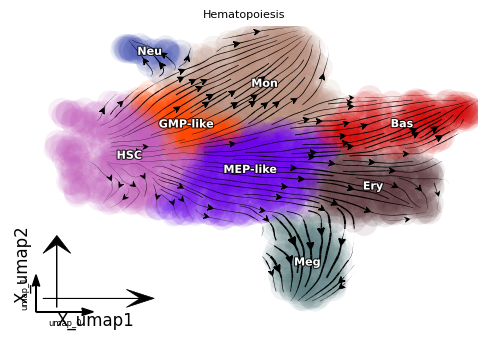

In [6]:
# %%
ax = dyn.pl.streamline_plot(adata, color=CLUSTER_KEY, basis="umap", show_legend="on data", show_arrowed_spines=True, size=(15,10), save_show_or_return='return')
ax[0].set_title("Hematopoiesis")
plt.show()

# %%
colors = {k:ax[0].get_children()[0]._facecolors[np.where(adata.obs[CLUSTER_KEY]==k)[0][0]] for k in adata.obs[CLUSTER_KEY].unique()}
for k in colors:
    colors[k][3] = 1

## 2. Load Scaffold from CellOracle

In [7]:
print("\n2. Loading CellOracle scaffold...")
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

# Create scaffold matrix
scaffold = pd.DataFrame(
    0,
    index=adata.var.index[genes_to_use],
    columns=adata.var.index[genes_to_use]
)

# Convert gene names to lowercase for case-insensitive comparison
tfs = list(set(base_GRN.columns.str.lower()) & set(scaffold.index.str.lower()))
target_genes = list(set(base_GRN['gene_short_name'].str.lower().values) & set(scaffold.columns.str.lower()))

# Map original names for assignment
index_map = {gene.lower(): gene for gene in scaffold.index}
col_map = {gene.lower(): gene for gene in scaffold.columns}

# Fill scaffold with 1s where connections exist
for tf in tfs:
    tf_original = index_map[tf]
    tf_base_GRN = [col for col in base_GRN.columns if col.lower() == tf][0]

    for target in base_GRN[base_GRN[tf_base_GRN] == 1]['gene_short_name']:
        if target.lower() in target_genes:
            target_original = col_map[target.lower()]
            scaffold.loc[tf_original, target_original] = 1

print(f"   Scaffold created: {scaffold.sum().sum()} potential connections")
print(f"   TFs: {len(tfs)}, Target genes: {len(target_genes)}")


2. Loading CellOracle scaffold...
   Scaffold created: 41693 potential connections
   TFs: 73, Target genes: 1148


In [8]:
sch.pp.fit_all_sigmoids(adata,
                         spliced_key=SPLICED_KEY,
                         genes=adata.var['use_for_dynamics'].values)

sch.pp.compute_sigmoid(adata, spliced_key=SPLICED_KEY, copy=False)

/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


In [9]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [10]:
sch.inf.fit_interactions(adata,
                         cluster_key=CLUSTER_KEY,
                         spliced_key=SPLICED_KEY,
                         velocity_key=VELOCITY_KEY,
                         degradation_key=DEGRADATION_KEY,
                         w_threshold=1e-12,
                         w_scaffold=scaffold.values,
                         scaffold_regularization=1e-2,
                         only_TFs=True,
                         infer_I=True,
                         refit_gamma=False,
                         pre_initialize_W=False,
                         n_epochs=1000,
                         criterion='MSE',
                         batch_size=128,
                         skip_all=True,
                         use_scheduler=True,
                         get_plots=False,
                         device='cuda')

Inferring interaction matrix W and bias vector I for cluster Mon


/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))
Training Epochs:   1%|          | 11/1000 [00:00<00:21, 45.94it/s]

[Epoch 1/1000] Total Loss: 1508.738800, Reconstruction Loss: 9.425094, Batch size: 39


Training Epochs:  12%|█▏        | 121/1000 [00:01<00:08, 102.10it/s]

[Epoch 101/1000] Total Loss: 594.368362, Reconstruction Loss: 0.070967, Batch size: 39


Training Epochs:  22%|██▏       | 220/1000 [00:02<00:07, 103.19it/s]

[Epoch 201/1000] Total Loss: 484.315353, Reconstruction Loss: 0.014794, Batch size: 39


Training Epochs:  32%|███▏      | 319/1000 [00:03<00:06, 103.11it/s]

[Epoch 301/1000] Total Loss: 443.178757, Reconstruction Loss: 0.002954, Batch size: 39


Training Epochs:  42%|████▏     | 418/1000 [00:04<00:05, 103.08it/s]

[Epoch 401/1000] Total Loss: 426.909027, Reconstruction Loss: 0.001520, Batch size: 39


Training Epochs:  52%|█████▏    | 517/1000 [00:05<00:04, 103.03it/s]

[Epoch 501/1000] Total Loss: 420.204895, Reconstruction Loss: 0.001294, Batch size: 39


Training Epochs:  62%|██████▏   | 616/1000 [00:06<00:03, 103.07it/s]

[Epoch 601/1000] Total Loss: 417.498741, Reconstruction Loss: 0.001339, Batch size: 39


Training Epochs:  72%|███████▏  | 715/1000 [00:07<00:02, 103.02it/s]

[Epoch 701/1000] Total Loss: 416.416656, Reconstruction Loss: 0.001356, Batch size: 39


Training Epochs:  81%|████████▏ | 814/1000 [00:08<00:01, 103.38it/s]

[Epoch 801/1000] Total Loss: 415.982758, Reconstruction Loss: 0.001335, Batch size: 39


Training Epochs:  91%|█████████▏| 913/1000 [00:09<00:00, 103.36it/s]

[Epoch 901/1000] Total Loss: 415.808876, Reconstruction Loss: 0.001352, Batch size: 39


Training Epochs: 100%|██████████| 1000/1000 [00:09<00:00, 101.36it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750595, Reconstruction Loss: 0.001361, Batch size: 39
Inferring interaction matrix W and bias vector I for cluster Meg


Training Epochs:   2%|▏         | 21/1000 [00:00<00:04, 206.75it/s]

[Epoch 1/1000] Total Loss: 1423.911560, Reconstruction Loss: 18.271353, Batch size: 26


Training Epochs:  14%|█▎        | 136/1000 [00:00<00:03, 221.62it/s]

[Epoch 101/1000] Total Loss: 632.133728, Reconstruction Loss: 0.134223, Batch size: 26


Training Epochs:  23%|██▎       | 228/1000 [00:01<00:03, 222.20it/s]

[Epoch 201/1000] Total Loss: 500.570312, Reconstruction Loss: 0.021295, Batch size: 26


Training Epochs:  34%|███▍      | 343/1000 [00:01<00:02, 222.72it/s]

[Epoch 301/1000] Total Loss: 449.489349, Reconstruction Loss: 0.008292, Batch size: 26


Training Epochs:  44%|████▎     | 435/1000 [00:01<00:02, 222.80it/s]

[Epoch 401/1000] Total Loss: 429.249084, Reconstruction Loss: 0.006945, Batch size: 26


Training Epochs:  53%|█████▎    | 527/1000 [00:02<00:02, 222.76it/s]

[Epoch 501/1000] Total Loss: 421.124298, Reconstruction Loss: 0.006789, Batch size: 26


Training Epochs:  64%|██████▍   | 642/1000 [00:02<00:01, 222.74it/s]

[Epoch 601/1000] Total Loss: 417.851089, Reconstruction Loss: 0.006448, Batch size: 26


Training Epochs:  73%|███████▎  | 734/1000 [00:03<00:01, 222.69it/s]

[Epoch 701/1000] Total Loss: 416.559448, Reconstruction Loss: 0.006658, Batch size: 26


Training Epochs:  83%|████████▎ | 826/1000 [00:03<00:00, 222.68it/s]

[Epoch 801/1000] Total Loss: 416.044724, Reconstruction Loss: 0.006593, Batch size: 26


Training Epochs:  94%|█████████▍| 941/1000 [00:04<00:00, 222.67it/s]

[Epoch 901/1000] Total Loss: 415.836685, Reconstruction Loss: 0.006680, Batch size: 26


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 222.36it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.757233, Reconstruction Loss: 0.006970, Batch size: 26
Inferring interaction matrix W and bias vector I for cluster MEP-like


Training Epochs:   1%|          | 10/1000 [00:00<00:10, 92.63it/s]

[Epoch 1/1000] Total Loss: 1503.215271, Reconstruction Loss: 5.390468, Batch size: 73


Training Epochs:  12%|█▏        | 120/1000 [00:01<00:09, 97.46it/s]

[Epoch 101/1000] Total Loss: 593.717239, Reconstruction Loss: 0.043151, Batch size: 73


Training Epochs:  22%|██▏       | 220/1000 [00:02<00:08, 97.33it/s]

[Epoch 201/1000] Total Loss: 483.674942, Reconstruction Loss: 0.009786, Batch size: 73


Training Epochs:  32%|███▏      | 320/1000 [00:03<00:06, 98.08it/s]

[Epoch 301/1000] Total Loss: 443.519554, Reconstruction Loss: 0.001880, Batch size: 73


Training Epochs:  42%|████▏     | 419/1000 [00:04<00:05, 100.21it/s]

[Epoch 401/1000] Total Loss: 426.967094, Reconstruction Loss: 0.000936, Batch size: 73


Training Epochs:  52%|█████▏    | 518/1000 [00:05<00:04, 100.33it/s]

[Epoch 501/1000] Total Loss: 420.221092, Reconstruction Loss: 0.000853, Batch size: 73


Training Epochs:  62%|██████▏   | 617/1000 [00:06<00:03, 99.94it/s] 

[Epoch 601/1000] Total Loss: 417.509857, Reconstruction Loss: 0.000843, Batch size: 73


Training Epochs:  72%|███████▏  | 716/1000 [00:07<00:02, 100.46it/s]

[Epoch 701/1000] Total Loss: 416.421104, Reconstruction Loss: 0.000860, Batch size: 73


Training Epochs:  82%|████████▏ | 815/1000 [00:08<00:01, 100.27it/s]

[Epoch 801/1000] Total Loss: 415.984062, Reconstruction Loss: 0.000866, Batch size: 73


Training Epochs:  91%|█████████▏| 914/1000 [00:09<00:00, 100.19it/s]

[Epoch 901/1000] Total Loss: 415.809349, Reconstruction Loss: 0.000871, Batch size: 73


Training Epochs: 100%|██████████| 1000/1000 [00:10<00:00, 99.32it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750412, Reconstruction Loss: 0.000878, Batch size: 73
Inferring interaction matrix W and bias vector I for cluster Ery


Training Epochs:   2%|▏         | 19/1000 [00:00<00:05, 186.47it/s]

[Epoch 1/1000] Total Loss: 1419.313568, Reconstruction Loss: 13.714968, Batch size: 106


Training Epochs:  14%|█▍        | 139/1000 [00:00<00:04, 196.24it/s]

[Epoch 101/1000] Total Loss: 626.795593, Reconstruction Loss: 0.101855, Batch size: 106


Training Epochs:  24%|██▍       | 239/1000 [00:01<00:03, 196.84it/s]

[Epoch 201/1000] Total Loss: 499.930740, Reconstruction Loss: 0.015982, Batch size: 106


Training Epochs:  34%|███▍      | 339/1000 [00:01<00:03, 196.64it/s]

[Epoch 301/1000] Total Loss: 449.348190, Reconstruction Loss: 0.003784, Batch size: 106


Training Epochs:  44%|████▍     | 439/1000 [00:02<00:02, 196.65it/s]

[Epoch 401/1000] Total Loss: 429.208847, Reconstruction Loss: 0.002316, Batch size: 106


Training Epochs:  54%|█████▍    | 539/1000 [00:02<00:02, 196.65it/s]

[Epoch 501/1000] Total Loss: 421.099823, Reconstruction Loss: 0.002088, Batch size: 106


Training Epochs:  64%|██████▍   | 639/1000 [00:03<00:01, 196.80it/s]

[Epoch 601/1000] Total Loss: 417.852386, Reconstruction Loss: 0.002083, Batch size: 106


Training Epochs:  74%|███████▍  | 739/1000 [00:03<00:01, 196.52it/s]

[Epoch 701/1000] Total Loss: 416.558319, Reconstruction Loss: 0.002084, Batch size: 106


Training Epochs:  84%|████████▍ | 839/1000 [00:04<00:00, 194.67it/s]

[Epoch 801/1000] Total Loss: 416.039917, Reconstruction Loss: 0.002078, Batch size: 106


Training Epochs:  94%|█████████▍| 939/1000 [00:04<00:00, 195.99it/s]

[Epoch 901/1000] Total Loss: 415.832443, Reconstruction Loss: 0.002081, Batch size: 106


Training Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 196.36it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.752502, Reconstruction Loss: 0.002081, Batch size: 106
Inferring interaction matrix W and bias vector I for cluster Bas


Training Epochs:   2%|▏         | 21/1000 [00:00<00:04, 207.63it/s]

[Epoch 1/1000] Total Loss: 1421.273560, Reconstruction Loss: 15.995173, Batch size: 49


Training Epochs:  13%|█▎        | 131/1000 [00:00<00:04, 214.49it/s]

[Epoch 101/1000] Total Loss: 631.394409, Reconstruction Loss: 0.131142, Batch size: 49


Training Epochs:  24%|██▍       | 241/1000 [00:01<00:03, 214.81it/s]

[Epoch 201/1000] Total Loss: 500.173416, Reconstruction Loss: 0.018433, Batch size: 49


Training Epochs:  33%|███▎      | 329/1000 [00:01<00:03, 214.84it/s]

[Epoch 301/1000] Total Loss: 449.324554, Reconstruction Loss: 0.004670, Batch size: 49


Training Epochs:  44%|████▍     | 439/1000 [00:02<00:02, 214.71it/s]

[Epoch 401/1000] Total Loss: 429.233826, Reconstruction Loss: 0.002921, Batch size: 49


Training Epochs:  53%|█████▎    | 527/1000 [00:02<00:02, 214.65it/s]

[Epoch 501/1000] Total Loss: 421.110565, Reconstruction Loss: 0.002852, Batch size: 49


Training Epochs:  64%|██████▎   | 637/1000 [00:02<00:01, 214.72it/s]

[Epoch 601/1000] Total Loss: 417.849503, Reconstruction Loss: 0.002592, Batch size: 49


Training Epochs:  72%|███████▎  | 725/1000 [00:03<00:01, 214.35it/s]

[Epoch 701/1000] Total Loss: 416.557205, Reconstruction Loss: 0.002710, Batch size: 49


Training Epochs:  84%|████████▎ | 835/1000 [00:03<00:00, 214.70it/s]

[Epoch 801/1000] Total Loss: 416.040482, Reconstruction Loss: 0.002622, Batch size: 49


Training Epochs:  92%|█████████▏| 923/1000 [00:04<00:00, 214.85it/s]

[Epoch 901/1000] Total Loss: 415.833099, Reconstruction Loss: 0.002763, Batch size: 49


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 214.63it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.753006, Reconstruction Loss: 0.002663, Batch size: 49
Inferring interaction matrix W and bias vector I for cluster GMP-like


Training Epochs:   2%|▏         | 21/1000 [00:00<00:04, 207.61it/s]

[Epoch 1/1000] Total Loss: 1412.144653, Reconstruction Loss: 6.811769, Batch size: 33


Training Epochs:  13%|█▎        | 131/1000 [00:00<00:04, 213.21it/s]

[Epoch 101/1000] Total Loss: 625.746063, Reconstruction Loss: 0.067102, Batch size: 33


Training Epochs:  24%|██▍       | 241/1000 [00:01<00:03, 213.24it/s]

[Epoch 201/1000] Total Loss: 500.077545, Reconstruction Loss: 0.008128, Batch size: 33


Training Epochs:  33%|███▎      | 330/1000 [00:01<00:03, 217.74it/s]

[Epoch 301/1000] Total Loss: 449.594025, Reconstruction Loss: 0.001659, Batch size: 33


Training Epochs:  44%|████▍     | 440/1000 [00:02<00:02, 218.60it/s]

[Epoch 401/1000] Total Loss: 429.264786, Reconstruction Loss: 0.000739, Batch size: 33


Training Epochs:  53%|█████▎    | 528/1000 [00:02<00:02, 218.78it/s]

[Epoch 501/1000] Total Loss: 421.137909, Reconstruction Loss: 0.000640, Batch size: 33


Training Epochs:  64%|██████▍   | 638/1000 [00:02<00:01, 218.84it/s]

[Epoch 601/1000] Total Loss: 417.867508, Reconstruction Loss: 0.000607, Batch size: 33


Training Epochs:  73%|███████▎  | 726/1000 [00:03<00:01, 217.68it/s]

[Epoch 701/1000] Total Loss: 416.563812, Reconstruction Loss: 0.000627, Batch size: 33


Training Epochs:  84%|████████▎ | 836/1000 [00:03<00:00, 218.61it/s]

[Epoch 801/1000] Total Loss: 416.041885, Reconstruction Loss: 0.000626, Batch size: 33


Training Epochs:  92%|█████████▏| 924/1000 [00:04<00:00, 218.75it/s]

[Epoch 901/1000] Total Loss: 415.832367, Reconstruction Loss: 0.000627, Batch size: 33


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 217.29it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.751617, Reconstruction Loss: 0.000630, Batch size: 33
Inferring interaction matrix W and bias vector I for cluster HSC


Training Epochs:   1%|▏         | 13/1000 [00:00<00:07, 127.85it/s]

[Epoch 1/1000] Total Loss: 1602.423055, Reconstruction Loss: 4.503673, Batch size: 53


Training Epochs:  12%|█▎        | 125/1000 [00:00<00:06, 134.29it/s]

[Epoch 101/1000] Total Loss: 605.680908, Reconstruction Loss: 0.062070, Batch size: 53


Training Epochs:  22%|██▏       | 223/1000 [00:01<00:05, 134.48it/s]

[Epoch 201/1000] Total Loss: 493.715668, Reconstruction Loss: 0.009470, Batch size: 53


Training Epochs:  32%|███▏      | 321/1000 [00:02<00:05, 134.20it/s]

[Epoch 301/1000] Total Loss: 447.419627, Reconstruction Loss: 0.002312, Batch size: 53


Training Epochs:  42%|████▏     | 419/1000 [00:03<00:04, 135.85it/s]

[Epoch 401/1000] Total Loss: 428.386444, Reconstruction Loss: 0.000827, Batch size: 53


Training Epochs:  52%|█████▏    | 517/1000 [00:03<00:03, 137.87it/s]

[Epoch 501/1000] Total Loss: 420.760895, Reconstruction Loss: 0.000642, Batch size: 53


Training Epochs:  62%|██████▏   | 615/1000 [00:04<00:02, 138.13it/s]

[Epoch 601/1000] Total Loss: 417.718018, Reconstruction Loss: 0.000645, Batch size: 53


Training Epochs:  73%|███████▎  | 727/1000 [00:05<00:01, 138.23it/s]

[Epoch 701/1000] Total Loss: 416.503408, Reconstruction Loss: 0.000644, Batch size: 53


Training Epochs:  82%|████████▎ | 825/1000 [00:06<00:01, 138.05it/s]

[Epoch 801/1000] Total Loss: 416.015676, Reconstruction Loss: 0.000655, Batch size: 53


Training Epochs:  92%|█████████▏| 923/1000 [00:06<00:00, 137.95it/s]

[Epoch 901/1000] Total Loss: 415.821493, Reconstruction Loss: 0.000662, Batch size: 53


Training Epochs: 100%|██████████| 1000/1000 [00:07<00:00, 136.56it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.749044, Reconstruction Loss: 0.000660, Batch size: 53
Inferring interaction matrix W and bias vector I for cluster Neu


Training Epochs:   5%|▌         | 50/1000 [00:00<00:01, 495.32it/s]

[Epoch 1/1000] Total Loss: 723.476562, Reconstruction Loss: 0.444766, Batch size: 32


Training Epochs:  10%|█         | 101/1000 [00:00<00:01, 499.83it/s]

[Epoch 101/1000] Total Loss: 636.961426, Reconstruction Loss: 0.412240, Batch size: 32


Training Epochs:  15%|█▌        | 152/1000 [00:00<00:01, 504.22it/s]

[Epoch 201/1000] Total Loss: 507.065613, Reconstruction Loss: 0.039391, Batch size: 32


Training Epochs:  26%|██▌       | 255/1000 [00:00<00:01, 505.76it/s]

[Epoch 301/1000] Total Loss: 451.596802, Reconstruction Loss: 0.008784, Batch size: 32


Training Epochs:  36%|███▌      | 358/1000 [00:00<00:01, 506.50it/s]

[Epoch 401/1000] Total Loss: 430.508545, Reconstruction Loss: 0.005125, Batch size: 32


Training Epochs:  46%|████▌     | 460/1000 [00:00<00:01, 506.21it/s]

[Epoch 501/1000] Total Loss: 421.669830, Reconstruction Loss: 0.004779, Batch size: 32


Training Epochs:  56%|█████▋    | 563/1000 [00:01<00:00, 506.63it/s]

[Epoch 601/1000] Total Loss: 418.063324, Reconstruction Loss: 0.004827, Batch size: 32


Training Epochs:  66%|██████▋   | 665/1000 [00:01<00:00, 506.06it/s]

[Epoch 701/1000] Total Loss: 416.649963, Reconstruction Loss: 0.004854, Batch size: 32


Training Epochs:  77%|███████▋  | 768/1000 [00:01<00:00, 507.02it/s]

[Epoch 801/1000] Total Loss: 416.078613, Reconstruction Loss: 0.004859, Batch size: 32


Training Epochs:  87%|████████▋ | 870/1000 [00:01<00:00, 506.54it/s]

[Epoch 901/1000] Total Loss: 415.849701, Reconstruction Loss: 0.004862, Batch size: 32


Training Epochs: 100%|██████████| 1000/1000 [00:01<00:00, 505.04it/s]


[Epoch 1000/1000] Total Loss: 415.757477, Reconstruction Loss: 0.004863, Batch size: 32


# Energies

In [11]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [12]:
# Compute energies using scHopfield
sch.tl.compute_energies(adata, cluster_key=CLUSTER_KEY)

In [13]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [14]:
summary_stats = adata.obs[[CLUSTER_KEY,'energy_total','energy_interaction','energy_degradation','energy_bias']].groupby(CLUSTER_KEY).describe()
for energy in summary_stats.columns.levels[0]:
    summary_stats[(energy,'cv')] = summary_stats[(energy,'std')]/summary_stats[(energy,'mean')]
summary_stats['energy_total']

count       mean       std       min        25%        50%  \
cell_type                                                               
Bas        177.0   7.795148  1.730734  3.758488   6.653501   8.294107   
Ery        234.0   6.892259  1.140401  3.413114   6.281704   6.741089   
GMP-like   161.0   4.354243  0.748733  3.297439   3.778166   4.057779   
HSC        309.0   4.244052  0.602303  3.171599   3.831892   4.116868   
MEP-like   457.0   4.885331  0.953895  3.513207   4.258830   4.591601   
Meg        154.0  10.669881  1.419062  5.716671  10.007463  10.755016   
Mon        423.0   5.776195  0.863813  3.331299   5.500494   5.807278   
Neu         32.0   8.906329  0.385957  7.272611   8.927892   9.038268   

                 75%        max        cv  
cell_type                                  
Bas         9.356992  10.217501  0.222027  
Ery         7.246715  12.044231  0.165461  
GMP-like    5.131370   6.247237  0.171955  
HSC         4.499643   7.272254  0.141917  
MEP-like    5.386476   9.595740  0.195257  
Meg        11.684605  12.876660  0.132997  
Mon         6.115415  12.709000  0.149547  
Neu         9.093512   9.246373  0.043335

array([<Axes3DSubplot: >], dtype=object)

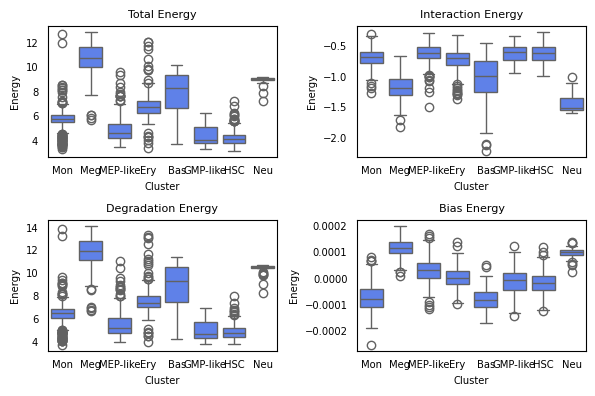

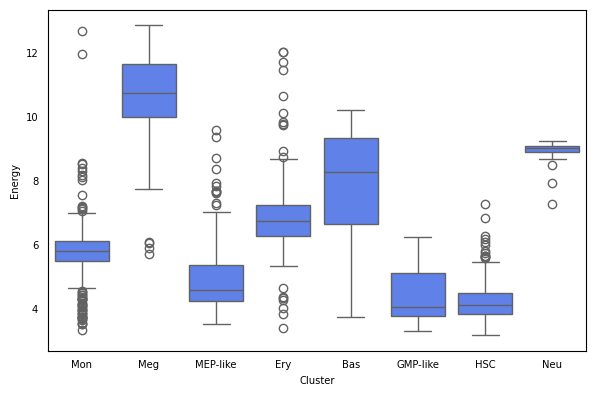

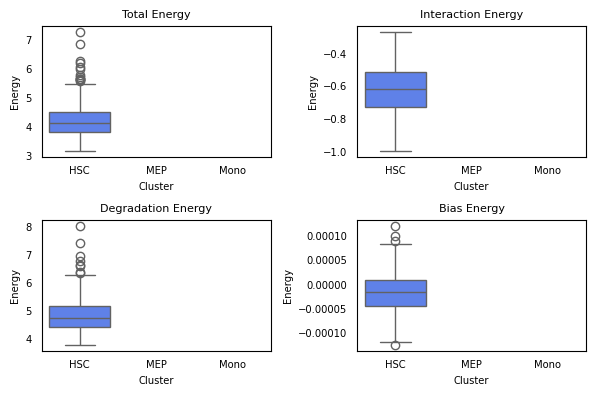

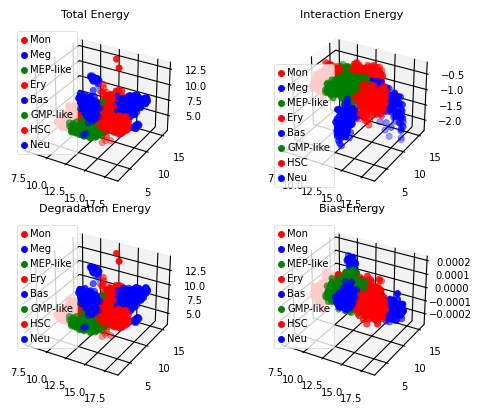

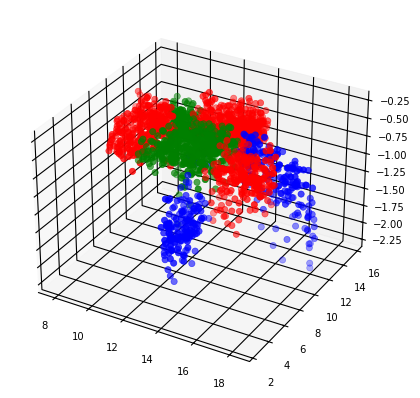

In [15]:
# Plot boxplots for all energy types
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type')

# Plot only total energy boxplot
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type', plot_energy='total')

# Plot with custom order and colors
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type',
                            order=['HSC', 'MEP', 'Mono'],
                            colors=['red', 'blue', 'green'])

# 3D scatter plots
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                            basis='umap', show_legend=True)

# Plot specific energy type
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                              plot_energy='interaction')

# Dendrograms

## Cell type dendrogram

In [16]:
# Compute celltype correlation using scHopfield
sch.tl.celltype_correlation(adata, spliced_key=SPLICED_KEY,cluster_key=CLUSTER_KEY)

<Figure size 900x300 with 0 Axes>

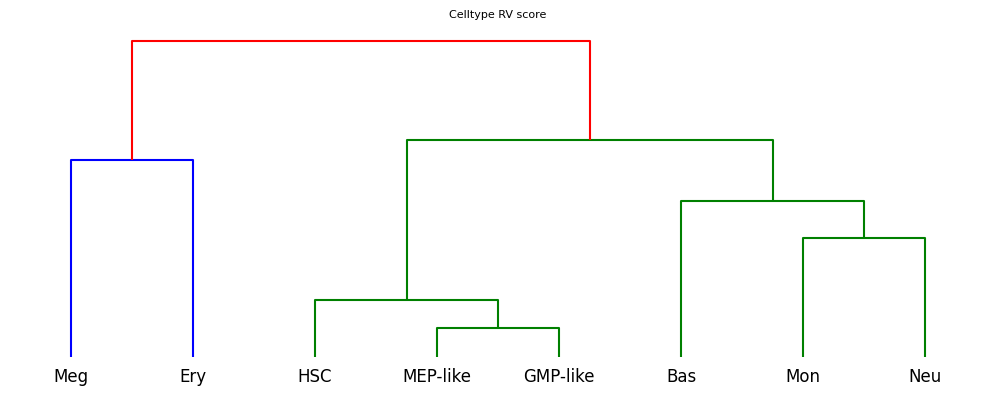

In [17]:
cells_correlation = adata.uns['scHopfield']['celltype_correlation']
plt.figure(figsize=(9, 3))
Z = scp.cluster.hierarchy.linkage(squareform(1-cells_correlation), 'complete')
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
scp.cluster.hierarchy.dendrogram(Z, labels = cells_correlation.index, ax=axs)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Celltype RV score')
plt.show()

## Network dendrogram

In [18]:
# Compute network correlations using scHopfield
sch.tl.network_correlations(adata, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [19]:
pearson = adata.uns['scHopfield']['network_correlations']['pearson']
hamming = adata.uns['scHopfield']['network_correlations']['hamming']
pearson_bin = adata.uns['scHopfield']['network_correlations']['pearson_bin']

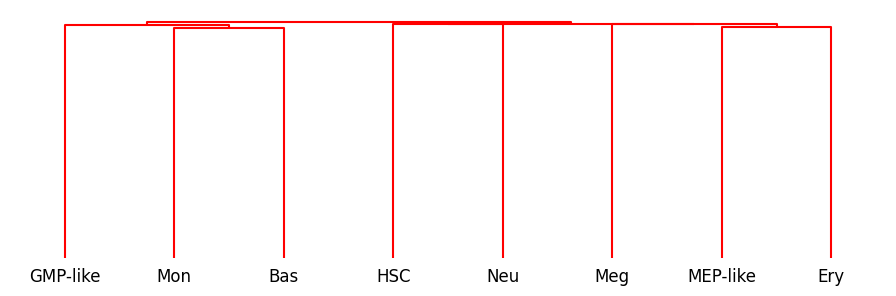

In [20]:
fig,axs = plt.subplots(1,1,figsize=(9, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson.index)
plt.show()

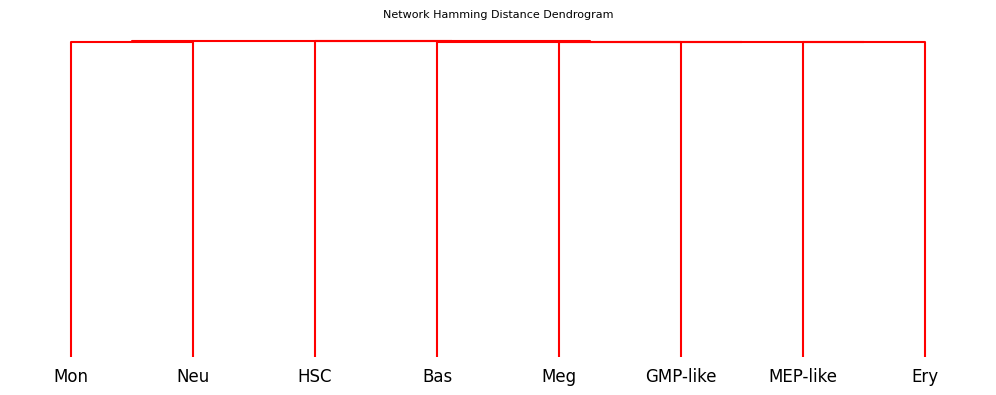

In [21]:
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Network Hamming Distance Dendrogram')

Z = scp.cluster.hierarchy.linkage(squareform(hamming), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = hamming.index)
plt.show()

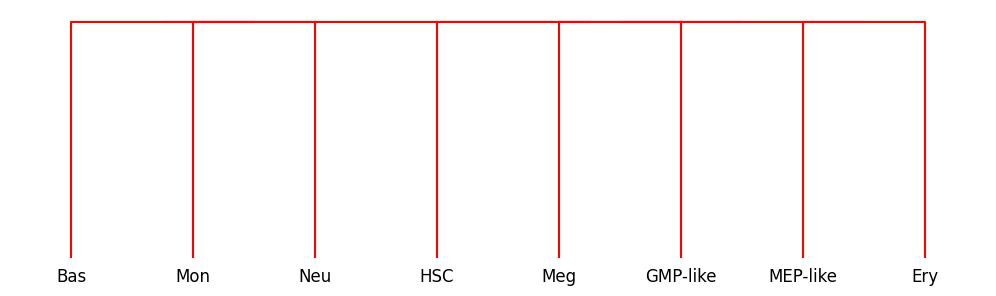

In [22]:
fig,axs = plt.subplots(1,1,figsize=(10, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson_bin), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson_bin.index)
plt.show()

# Symmetricity

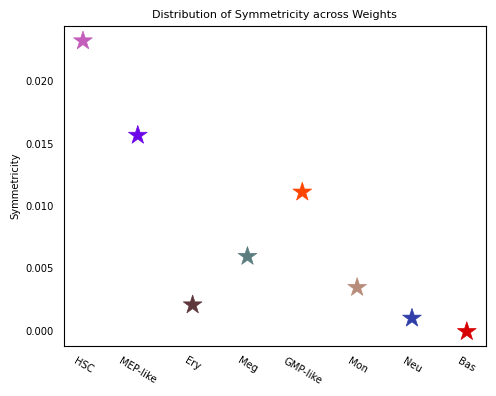

In [23]:
def symmetricity(A, norm=2):
    S = np.linalg.norm((A+A.T)/2, ord=norm)
    As = np.linalg.norm((A-A.T)/2, ord=norm)
    return (S-As)/(S+As)

# Get interaction matrices from scHopfield storage
W = {}
genes_used = adata.var['use_for_dynamics'].values
gene_names = adata.var_names[genes_used]
for cluster in CELL_TYPE_ORDER:
    W[cluster] = adata.varp[f'W_{cluster}'][genes_used][:,genes_used]

syms = np.array([symmetricity(W[k], norm=2) for k in CELL_TYPE_ORDER])
idxs = np.argsort(syms)
plt.figure(figsize=(5,4), tight_layout=True)
plt.scatter(range(len(W)), syms, s=200, marker='*', c=[colors[i] for i in CELL_TYPE_ORDER])
plt.xticks(range(len(W)), np.array(CELL_TYPE_ORDER))
plt.ylabel('Symmetricity')
plt.xticks(rotation=-30)
plt.title('Distribution of Symmetricity across Weights')
plt.show()

# Model Analysis

In [24]:
gamma = {}
I = {}
for cluster in CELL_TYPE_ORDER:
    gamma[cluster] = adata.var[f'gamma_{cluster}'].values[genes_used] if f'gamma_{cluster}' in adata.var.columns else adata.var[DEGRADATION_KEY].values[genes_used]
    I[cluster] = adata.var[f'I_{cluster}'].values[genes_used] if f'I_{cluster}' in adata.var.columns else np.zeros(genes_used.sum())

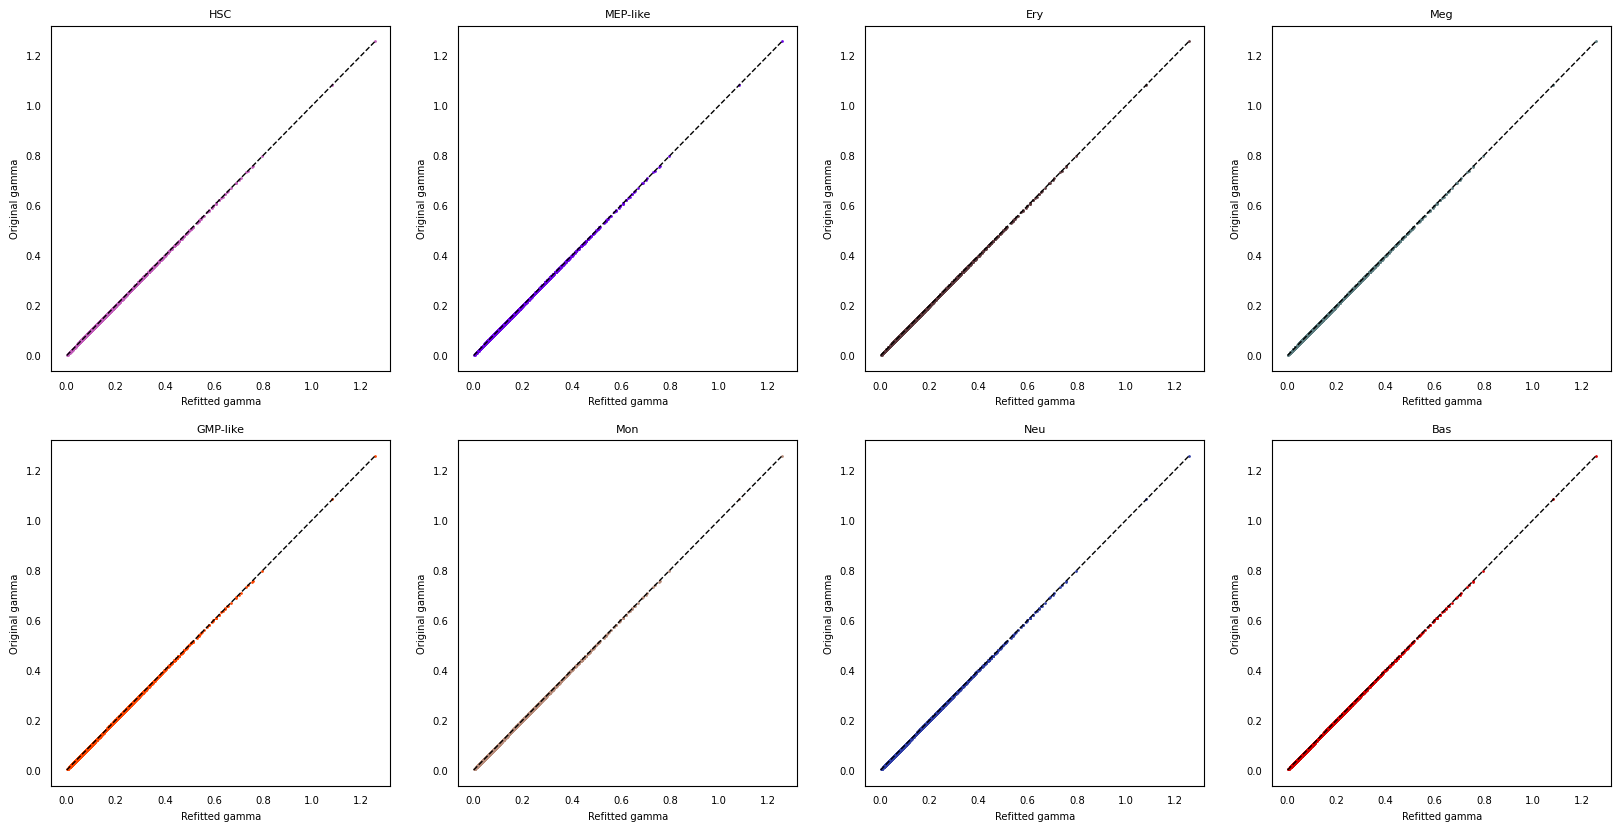

In [25]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
    ax.scatter(gamma[cl], adata.var[DEGRADATION_KEY][genes_used], color=colors[cl], s=2)
    ax.set_title(cl)
    max_gamma = max(np.concatenate([gamma[cl], adata.var[DEGRADATION_KEY][genes_used]]))
    ax.set_xlabel('Refitted gamma')
    ax.set_ylabel('Original gamma')
    ax.plot([0, max_gamma], [0, max_gamma], color='k', ls='--', lw=1)
plt.show()

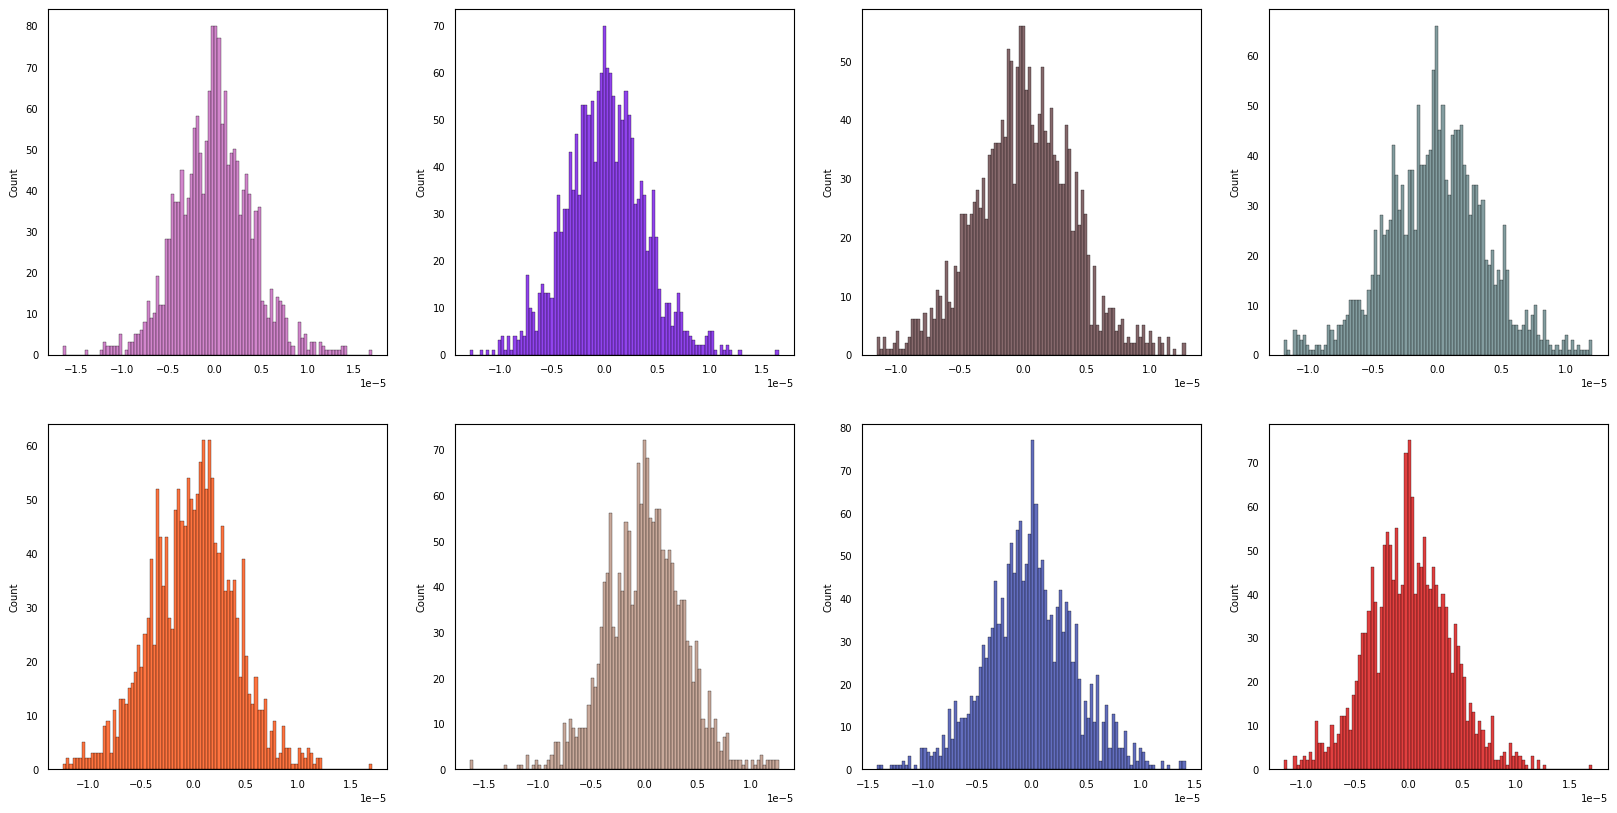

In [26]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
   sns.histplot(I[cl].flatten(), bins=100,ax=ax, color=colors[cl])
plt.show()

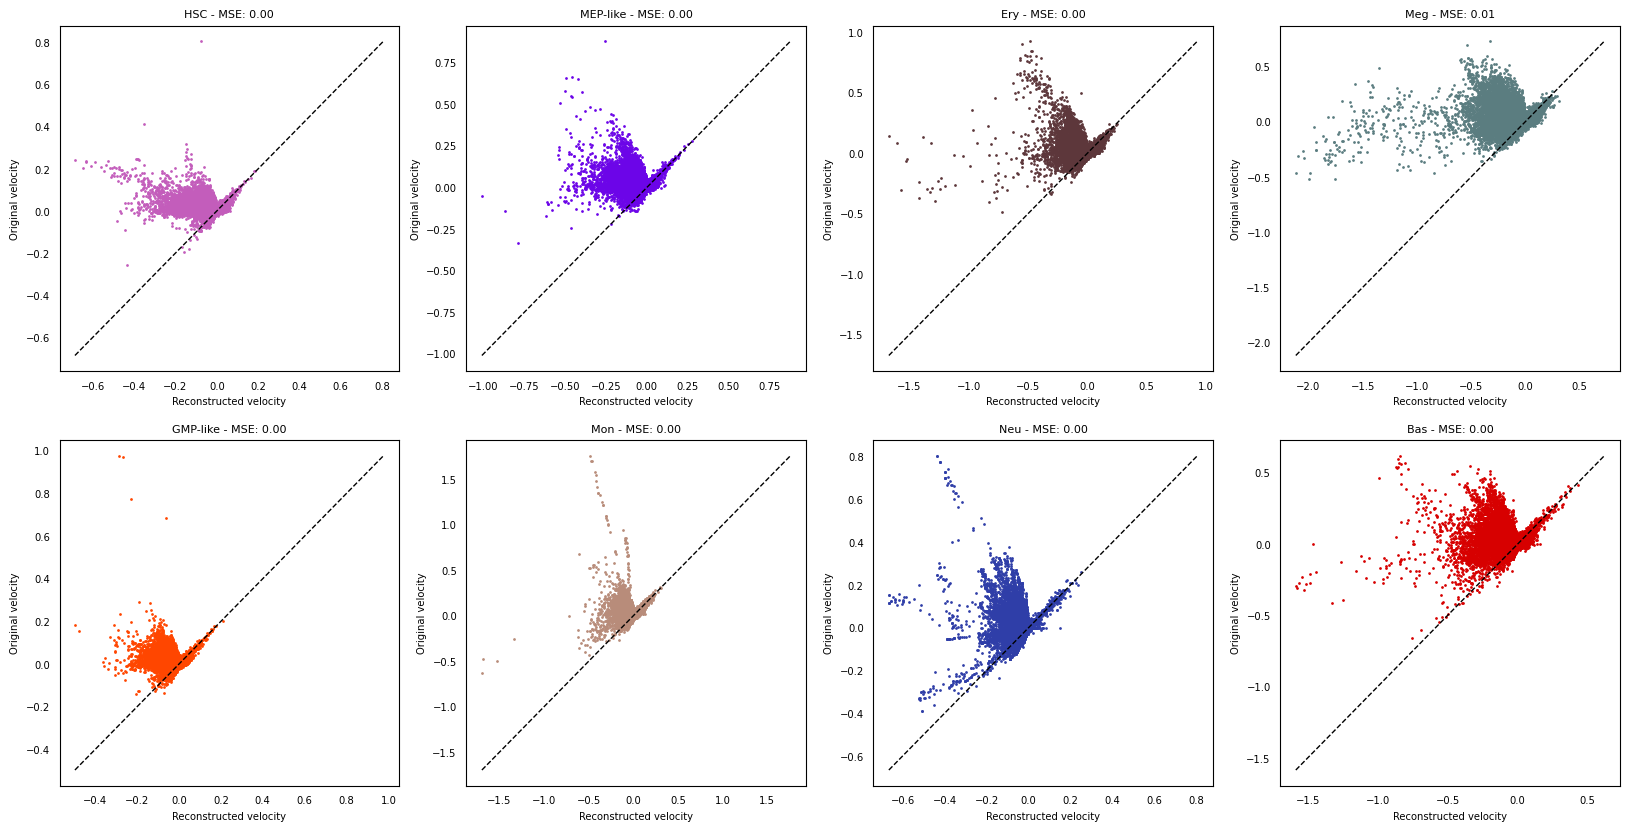

In [27]:
# Get MSE for each cluster
mse_dict = sch.tl.validate_velocity(
    adata,
    velocity_key=VELOCITY_KEY,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    return_mse=False  # Returns dict with per-cluster MSE
)

# Then plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for cl, ax in zip(CELL_TYPE_ORDER, axs.flatten()):
    reconstructed_v = sch.tl.compute_reconstructed_velocity(
        adata, cluster=cl, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY
    )

    genes_used = sch._utils.io.get_genes_used(adata)
    cluster_mask = (adata.obs[CLUSTER_KEY] == cl).values
    original_v = adata.layers[VELOCITY_KEY][cluster_mask][:, genes_used]

    ax.scatter(reconstructed_v.flatten(), original_v.toarray().flatten(), color=colors[cl], s=2)
    ax.set_title(f'{cl} - MSE: {mse_dict[cl]:.2f}')
    ax.set_xlabel('Reconstructed velocity')
    ax.set_ylabel('Original velocity')

    min_v = min(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    max_v = max(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    ax.plot([min_v, max_v], [min_v, max_v], c='k', ls='--', lw=1)

plt.show()

# Correlations

In [28]:
# Compute energy-gene correlations using scHopfield
sch.tl.energy_gene_correlation(adata, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered i

In [29]:
df_correlations = sch.tl.get_correlation_table(
      adata,
      cluster_key=CLUSTER_KEY,
      energy_type='total',  # or 'interaction', 'degradation', 'bias'
      n_top_genes=100,
      order=CELL_TYPE_ORDER  # optional: specify cluster order
  )
df_correlations

HSC                MEP-like                 Ery                 Meg  \
        Gene Correlation        Gene Correlation    Gene Correlation    Gene   
0       CRYM    0.737346        RORA    0.830190  DIAPH1    0.852088   LTBP1   
1       RORA    0.705890    SLC30A10    0.820414  ITGA2B    0.833800    GPX1   
2   SLC30A10    0.701958  AC108519.1    0.813708  HEXIM1    0.830324     GSN   
3      TIAM1    0.696218     PGAM1P5    0.811259   PTGS1    0.824689  FERMT3   
4      EXTL3    0.692958       MBNL3    0.811003   IL21R    0.823002   MMRN1   
..       ...         ...         ...         ...     ...         ...     ...   
95   PLEKHG3    0.443919       IGF2R    0.553628   F13A1    0.671139     CD9   
96      NOL6    0.442104         EYS    0.553023  SAMD14    0.669286    MCL1   
97      APRT    0.441390     SMARCD2    0.549768  SH3BP5    0.669271  C2CD2L   
98     INTS5    0.441318        CTSD    0.548752   ITGB5    0.668799  NCKAP1   
99     DDX41    0.439977     CDK2AP2    0.548398     MN1    0.667604    FLI1   

                  GMP-like                  Mon                  Neu  \
   Correlation        Gene Correlation     Gene Correlation     Gene   
0     0.938839        RORA    0.870089     GPX1    0.688678  S100A11   
1     0.925360     PGAM1P5    0.868377     PPIF    0.686097    FMNL3   
2     0.918873       MBNL3    0.866196  PGAM1P5    0.655643    CD151   
3     0.909913       EXTL3    0.865318     LMNA    0.644500     LGMN   
4     0.907967       TIAM1    0.860159     PATJ    0.641622    PPM1F   
..         ...         ...         ...      ...         ...      ...   
95    0.746809      PLCXD1    0.602434   HEXIM1    0.504365     MYL6   
96    0.746617       PSMB3    0.602084  KANSL1L    0.502795   RASAL1   
97    0.744958  AL035446.2    0.601601    RAB3C    0.499671     SRGN   
98    0.742343       FLOT2    0.601468    VPS18    0.499470     EMP3   
99    0.742208        BYSL    0.601174  ATP6AP1    0.494737    FLOT1   

                      Bas              
   Correlation       Gene Correlation  
0     0.908059        LIF    0.902770  
1     0.900661      CKAP4    0.898452  
2     0.893773       JUND    0.888915  
3     0.889513      AHNAK    0.878446  
4     0.888788       MYL6    0.874276  
..         ...        ...         ...  
95    0.814097  LINC00623    0.741275  
96    0.813610      IL2RG    0.739612  
97    0.813317      MS4A2    0.738824  
98    0.812746       PATJ    0.734448  
99    0.811827       CTSB    0.734158  

[100 rows x 16 columns]

In [30]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [31]:
# Get genes used in analysis
genes = sch._utils.io.get_genes_used(adata)
gene_names = adata.var.index[genes]

# Build correlation dictionary from adata.var columns
correlation = {}
for cluster in CELL_TYPE_ORDER:
    corr_col = f'correlation_total_{cluster}'
    if corr_col in adata.var.columns:
        correlation[cluster] = adata.var[corr_col].values[genes]
    else:
        print(f"Warning: No correlation data for {cluster}")

# Also check for 'all' if it exists
if 'correlation_total_all' in adata.var.columns:
    correlation['all'] = adata.var['correlation_total_all'].values[genes]

# Find corner genes
corner_genes = np.array([])
clus1_low = -0.4
clus1_high = 0.4
clus2_low = -0.4
clus2_high = 0.4
nn = 5

for corr1, corr2 in itertools.combinations(CELL_TYPE_ORDER, 2):
    if corr1 not in correlation or corr2 not in correlation:
        continue

    corr1_vals = correlation[corr1]
    corr2_vals = correlation[corr2]

    positions_corners = np.logical_or(
        np.logical_and(corr1_vals >= clus1_high, corr2_vals <= clus2_low),
        np.logical_and(corr1_vals <= clus1_low, corr2_vals >= clus2_high)
    )

    corr_corners = np.where(positions_corners)[0]
    corr_indices = np.argsort((corr1_vals[corr_corners])**2 + (corr2_vals[corr_corners])**2)[-nn:]
    corr_corners = corr_corners[corr_indices]
    corner_genes = np.concatenate((corner_genes, gene_names[corr_corners]))

corner_genes = np.unique(corner_genes)

# Create DataFrame from correlation dictionary
df_corr_corners = pd.DataFrame.from_dict(correlation)
df_corr_corners.drop('all', axis=1, inplace=True, errors='ignore')
df_corr_corners.index = gene_names
df_corr_corners = df_corr_corners.loc[corner_genes]

print(f"Found {len(corner_genes)} corner genes")

Found 55 corner genes


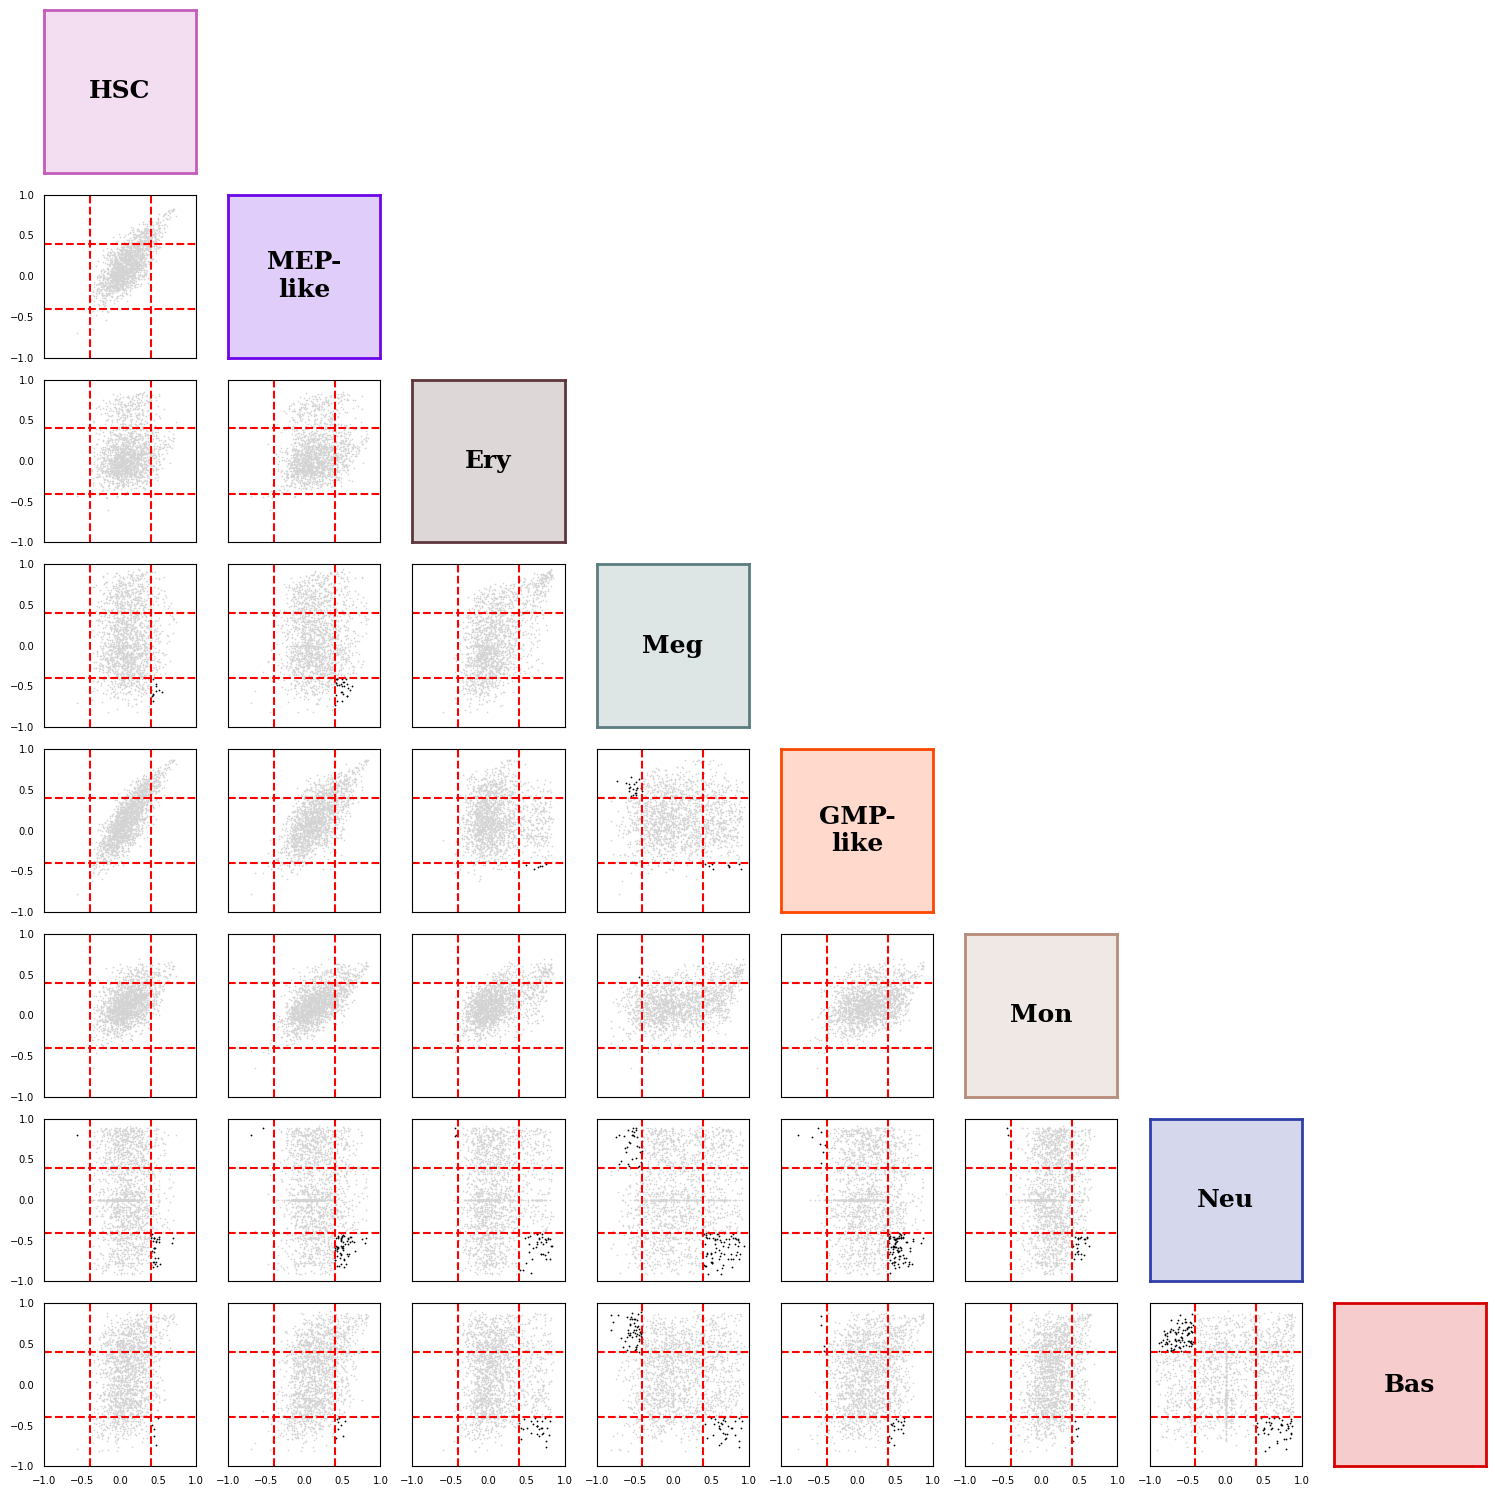

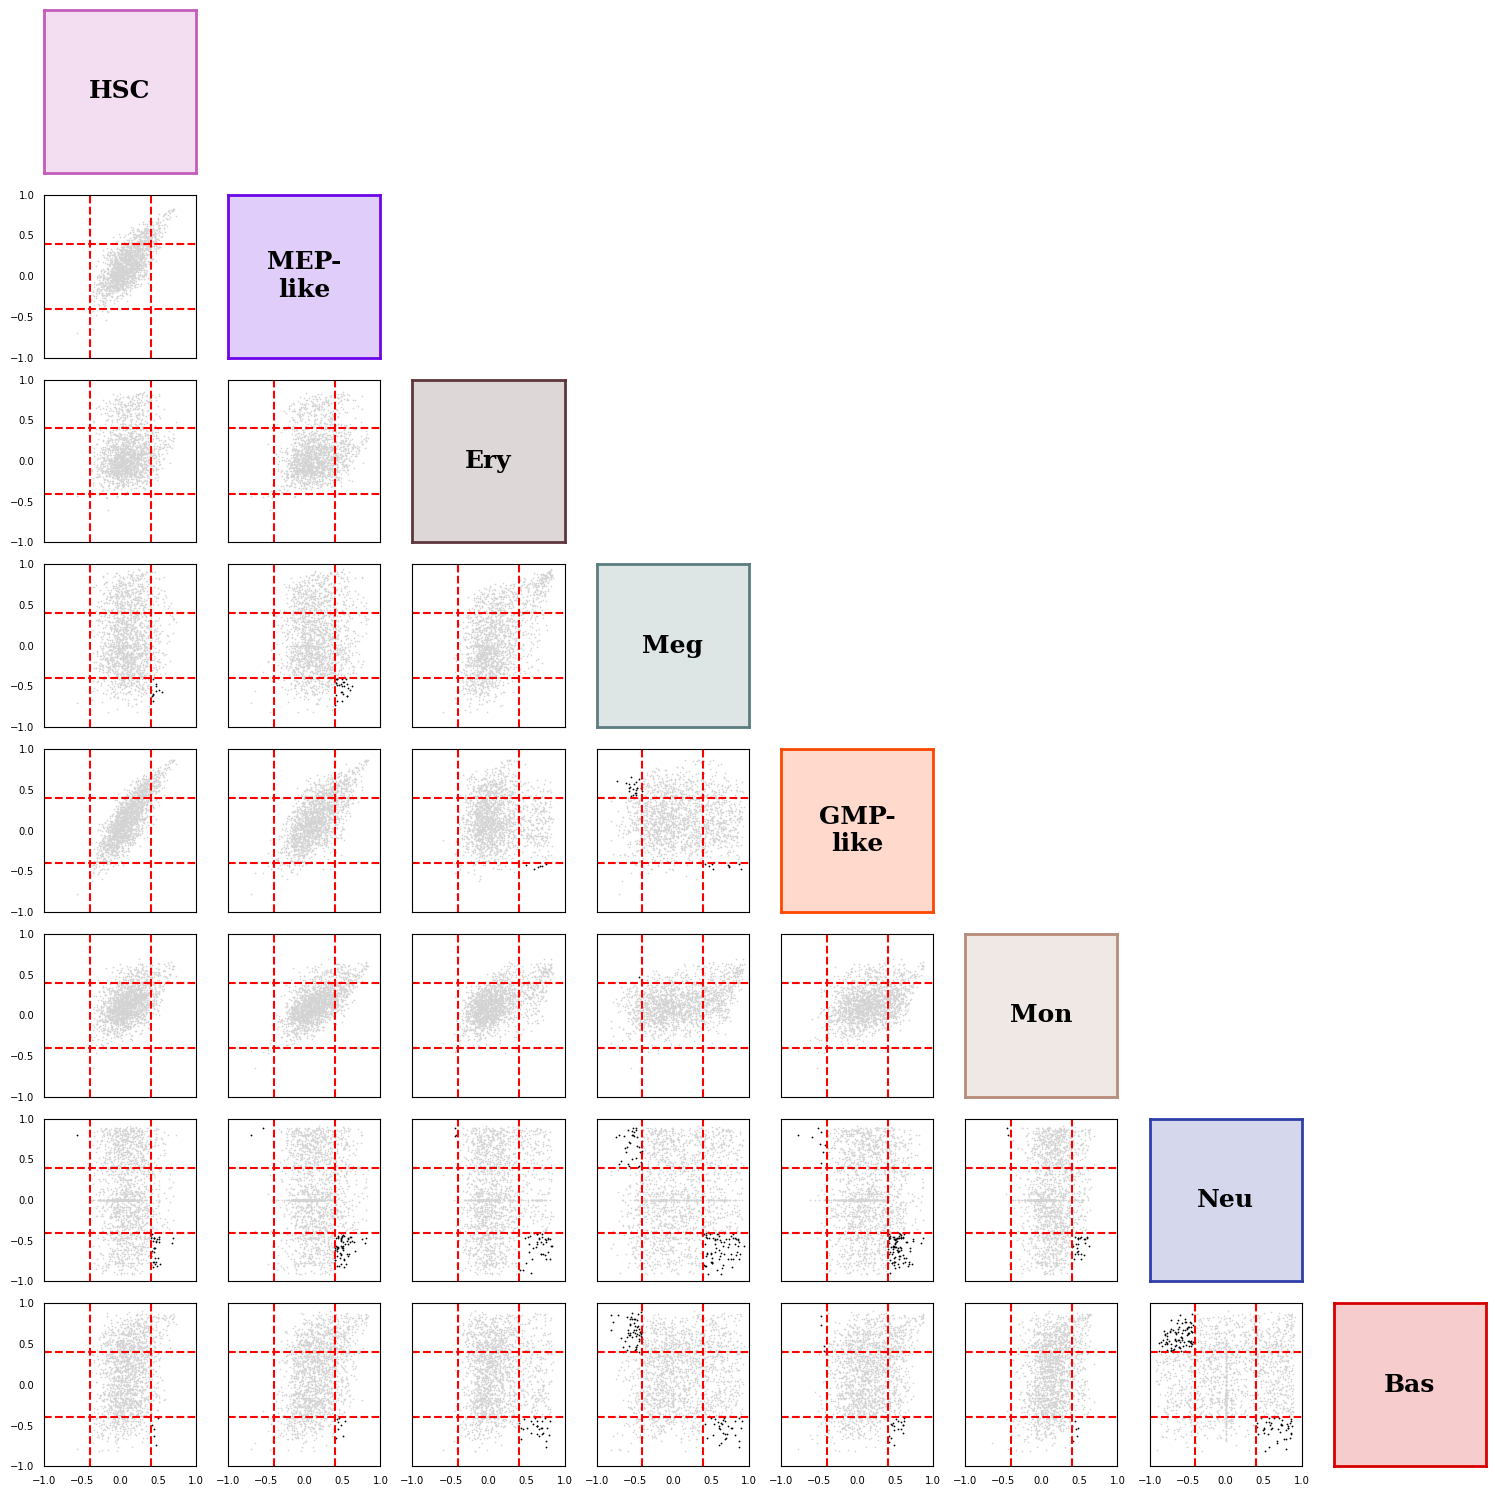

In [32]:
sch.pl.plot_correlations_grid(
      adata,
      cluster_key=CLUSTER_KEY,
      energy='total',
      order=CELL_TYPE_ORDER,
      colors=colors,
      x_low=-0.4,
      x_high=0.4,
      y_low=-0.4,
      y_high=0.4
  )

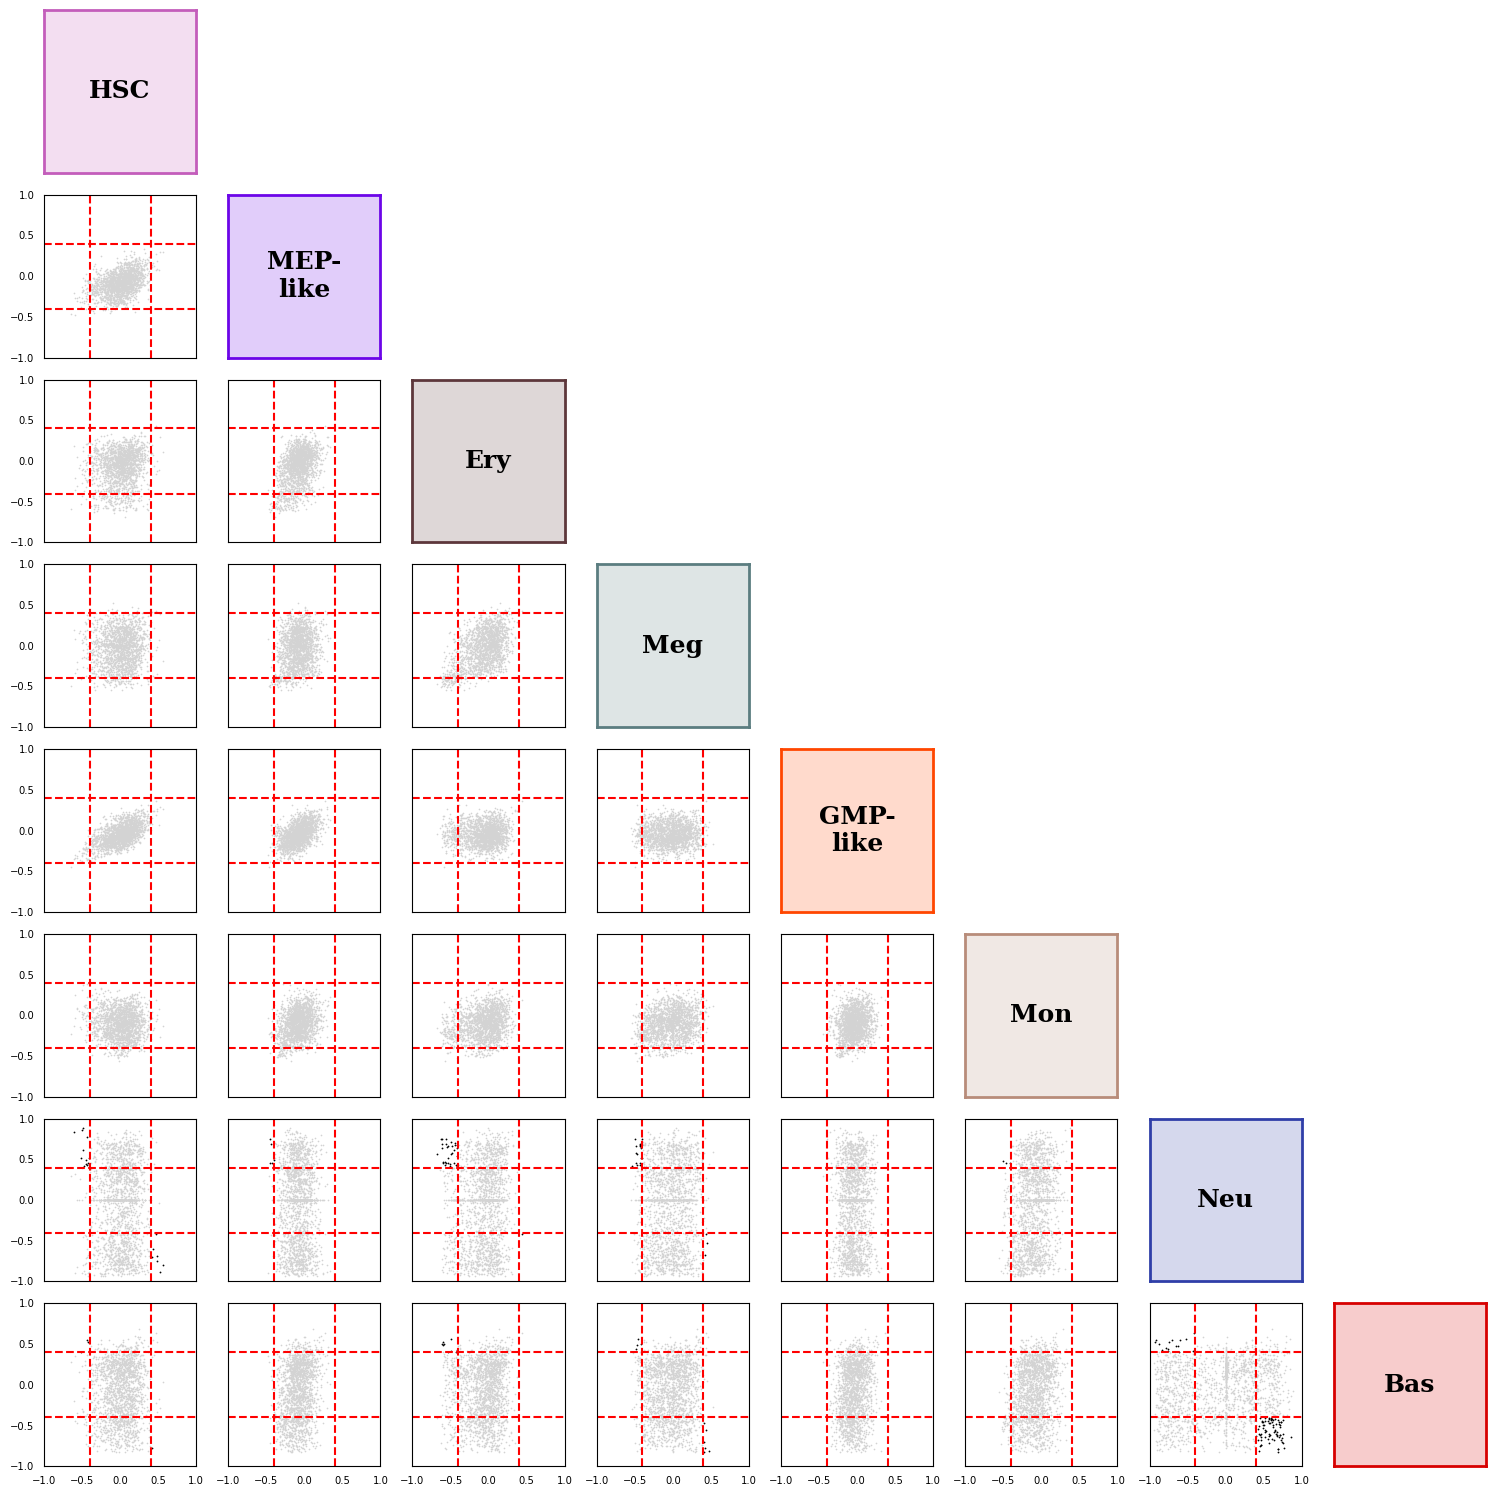

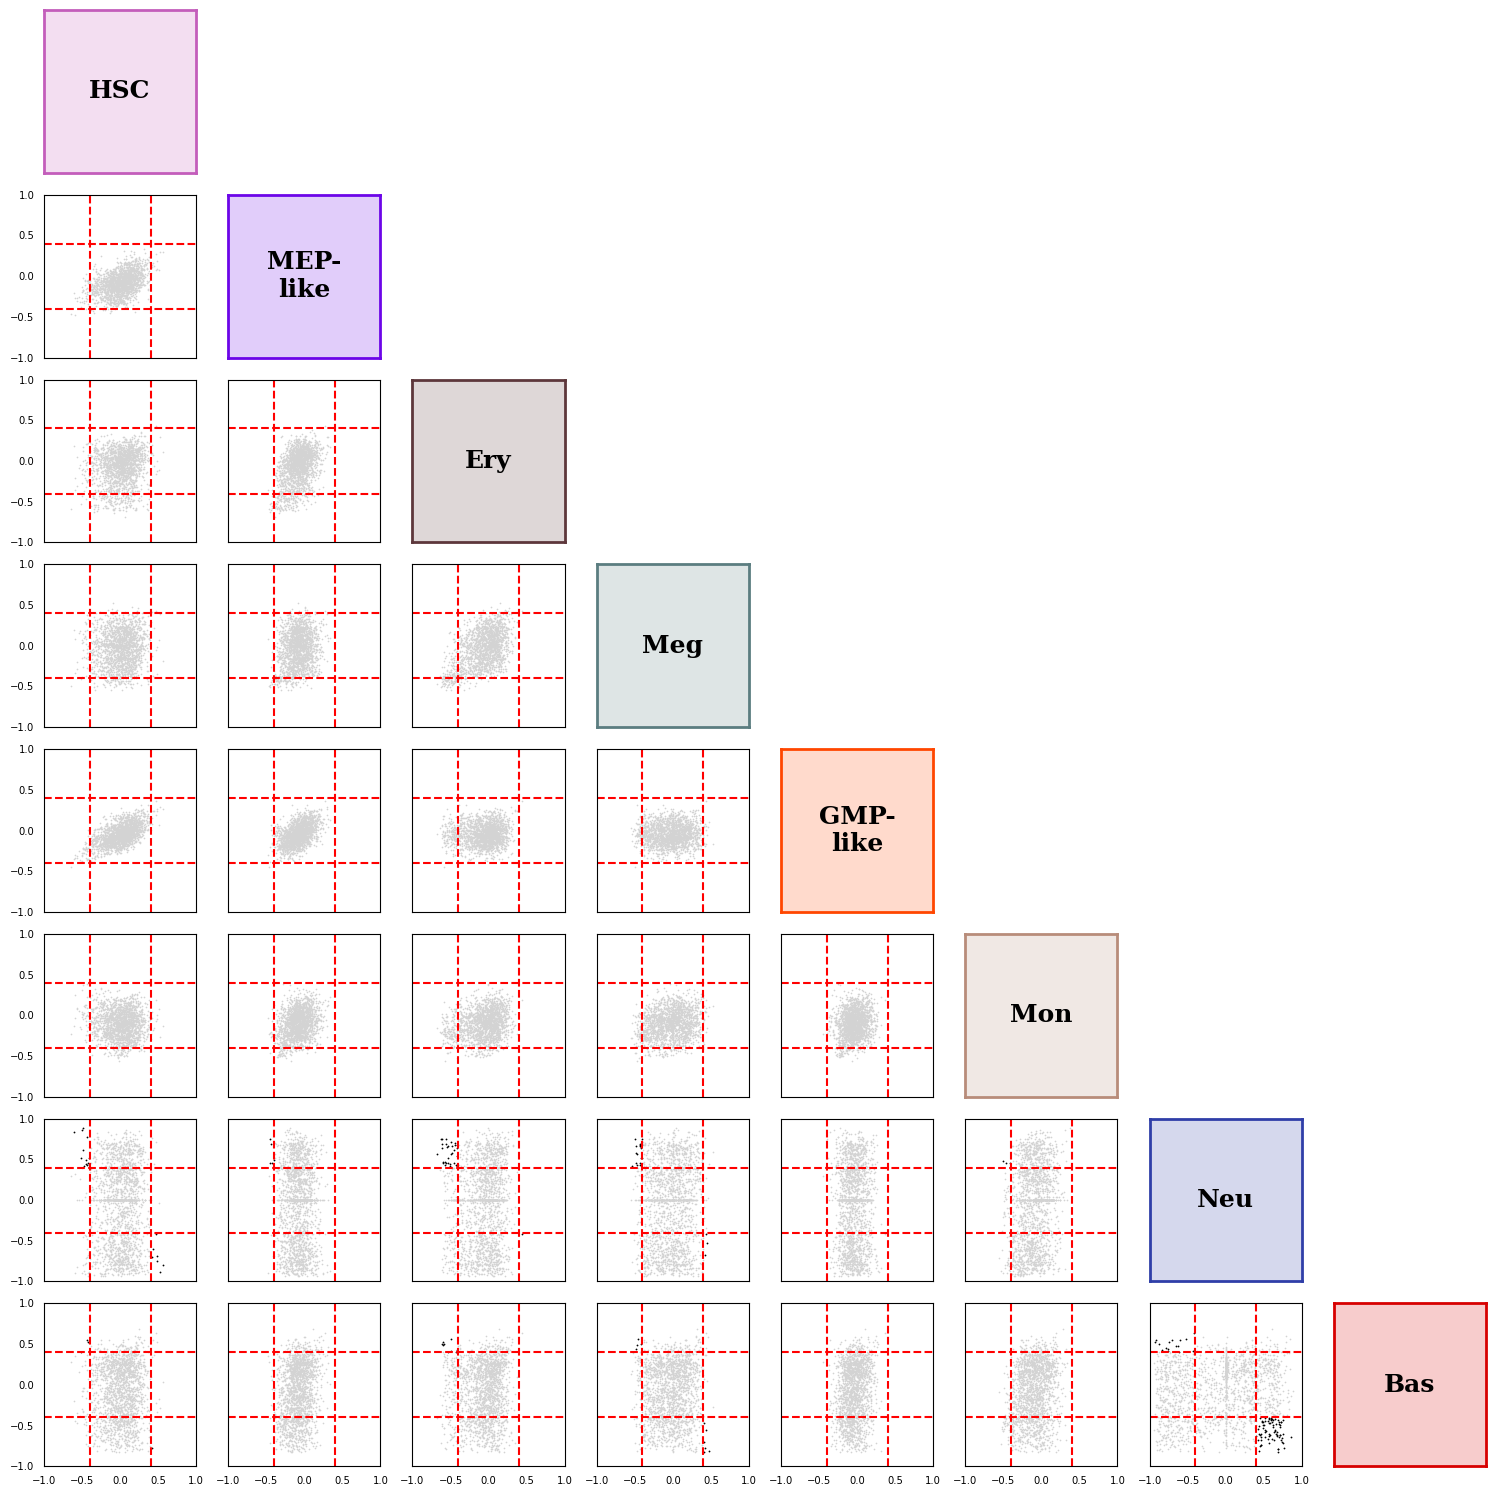

In [33]:
sch.pl.plot_correlations_grid(
      adata,
      cluster_key=CLUSTER_KEY,
      energy='interaction',
      order=CELL_TYPE_ORDER,
      colors=colors,
      x_low=-0.4,
      x_high=0.4,
      y_low=-0.4,
      y_high=0.4
  )

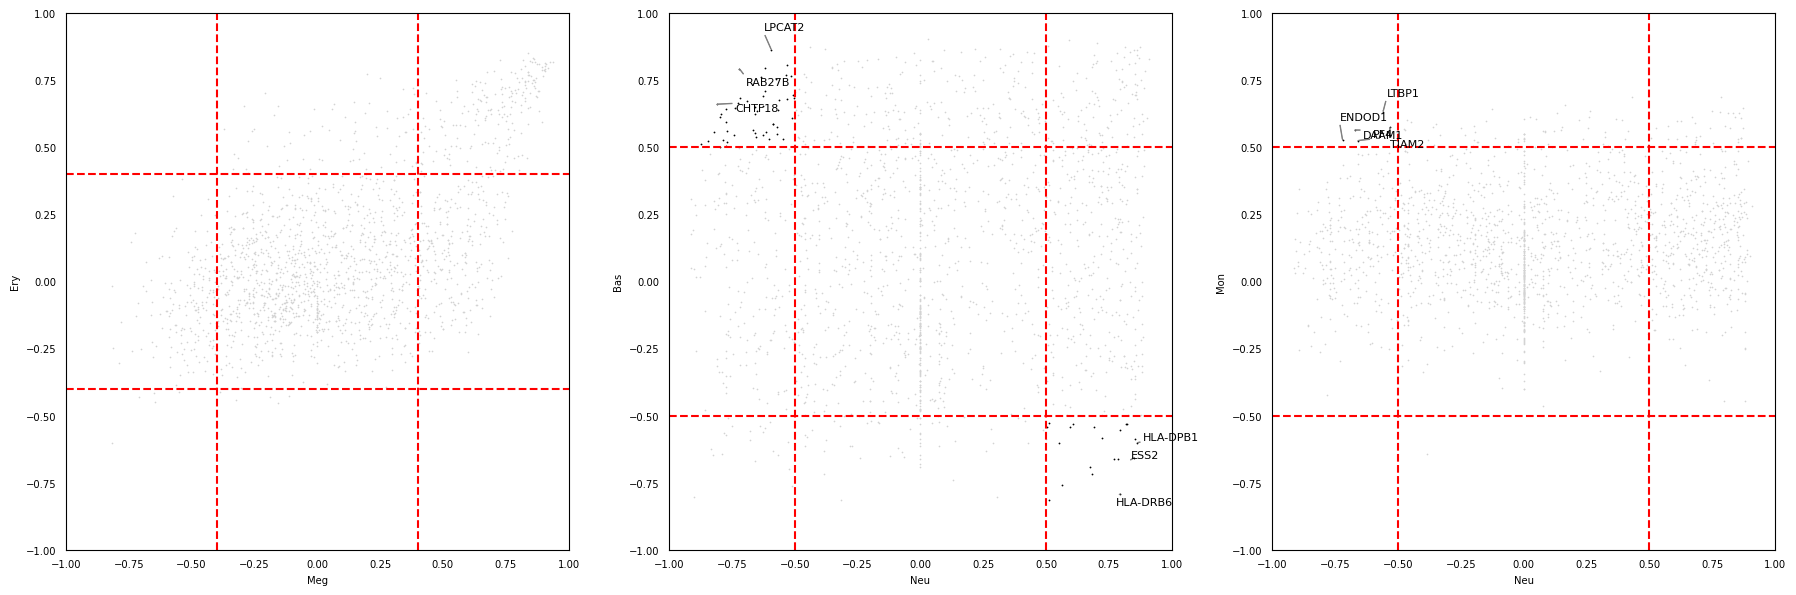

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)

sch.pl.plot_gene_correlation_scatter(adata, 'Meg', 'Ery', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[0], clus1_low=-0.4, clus1_high=0.4,
clus2_low=-0.4, clus2_high=0.4)
sch.pl.plot_gene_correlation_scatter(adata, 'Neu', 'Bas', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[1])
sch.pl.plot_gene_correlation_scatter(adata, 'Neu', 'Mon', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[2])

plt.show()


# Network scores

In [35]:
sch.tl.compute_network_centrality(
      adata,
      cluster_key='cell_type',
      threshold_number=2000  # Top 2000 edges per cluster
  )

In [36]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

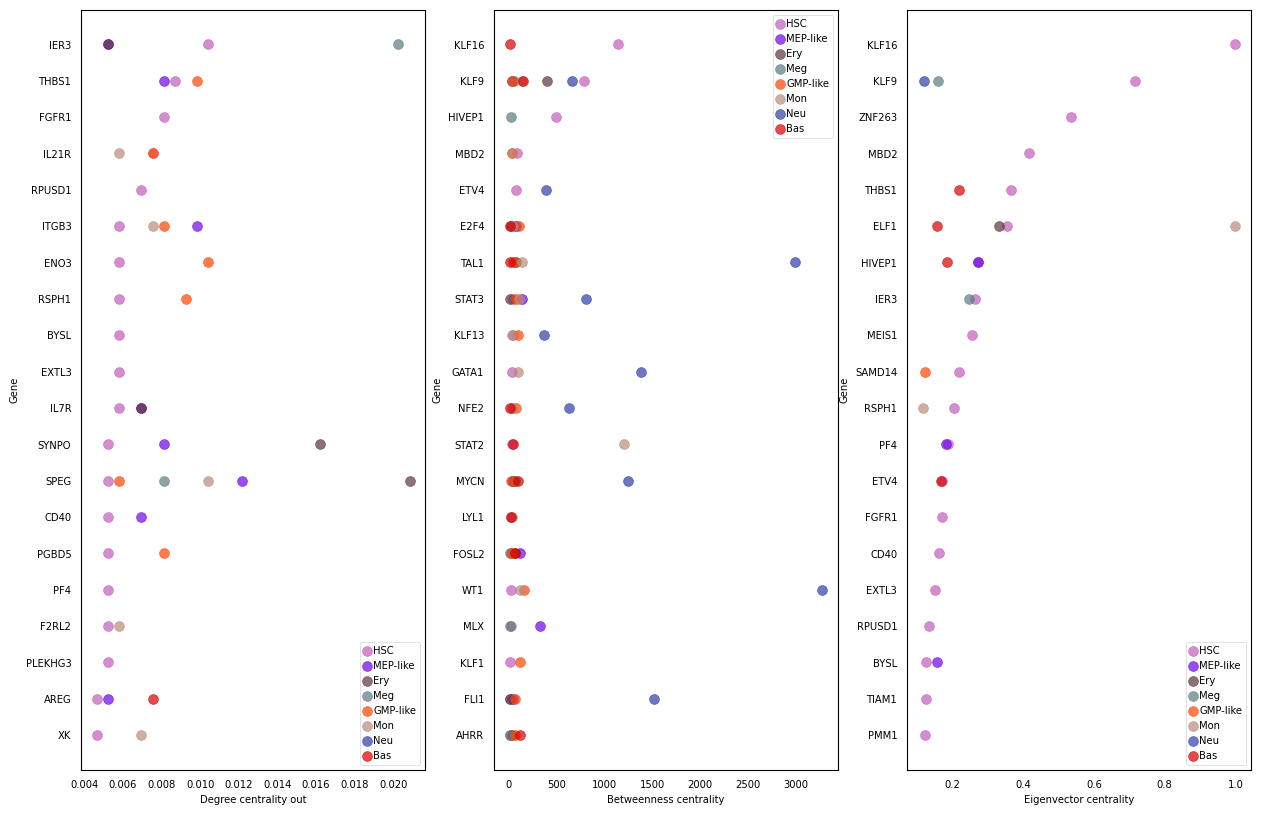

In [37]:
# ============================================================
# 2. Plot ranked genes by different centrality metrics
# ============================================================
# Create figure with multiple centrality rankings
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

metrics = ['degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
for ax, metric in zip(axes, metrics):
    sch.pl.plot_network_centrality_rank(
        adata,
        metric=metric,
        clusters=CELL_TYPE_ORDER,
        cluster_key=CLUSTER_KEY,
        n_genes=20,
        colors=colors,
        ax=ax
    )
plt.show()

In [38]:
# ============================================================
# 3. Get top genes tables for different metrics
# ============================================================
# Betweenness centrality table
df_betweenness = sch.tl.get_top_genes_table(
    adata,
    metric='betweenness_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER,
)
display(df_betweenness)

# Degree centrality table
df_degree = sch.tl.get_top_genes_table(
    adata,
    metric='degree_centrality_out',
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER,
)
display(df_degree)

# Eigenvector centrality table
df_eigenvector = sch.tl.get_top_genes_table(
    adata,
    metric='eigenvector_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=10,
    order=CELL_TYPE_ORDER,
)
display(df_eigenvector)

# Get just the gene names (every other column)
genes_only = df_degree[[((cl, 'Gene')) for cl in CELL_TYPE_ORDER]]
display(genes_only)

HSC                        MEP-like                           Ery  \
      Gene Betweenness Centrality     Gene Betweenness Centrality   Gene   
0    KLF16                 1141.0     TCF3                  618.0  CEBPA   
1     KLF9                  784.0      MLX                  327.0   ELF1   
2   HIVEP1                  492.0    STAT3                  137.0   KLF9   
3     MBD2                   88.0    GATA2                  136.0  MYPOP   
4     ETV4                   70.0      SP2                  124.0   TAL1   
5     E2F4                   49.0    FOSL2                  121.0   EBF1   
6     TAL1                   46.0     EBF1                  110.0  FOSL2   
7    STAT3                   46.0     E2F4                   75.0   ETV6   
8    KLF13                   40.0     MYCN                   52.0   MYCN   
9    GATA1                   36.0     JUND                   50.0  NR4A1   
10    NFE2                   32.0     FLI1                   43.0    ERG   
11   STAT2                   31.0     ELF1                   42.0  GATA2   
12    MYCN                   26.0      ID2                   41.0   AHRR   
13    LYL1                   24.0     KLF9                   38.0   E2F4   
14   FOSL2                   22.0     SPI1                   34.0   JUND   
15     WT1                   21.0    NR4A1                   32.0   TCF3   
16     MLX                   20.0    RUNX1                   31.0   RORA   
17    KLF1                   17.0     LMO2                   28.0   CUX1   
18    FLI1                   16.0     ETV6                   27.0  STAT3   
19    AHRR                   16.0     RFX1                   20.0   FLI1   

                              Meg                        GMP-like  \
   Betweenness Centrality    Gene Betweenness Centrality     Gene   
0                  1165.0    TCF3                  511.0    GATA2   
1                   860.0   CEBPA                  156.0      SP2   
2                   401.0   ITGB2                   75.0     JUND   
3                   247.0    GFI1                   70.0    NR4A1   
4                    75.0    MYCN                   68.0      WT1   
5                    75.0    KLF9                   53.0     TCF3   
6                    64.0     HLF                   44.0      ID2   
7                    50.0  GTF3C2                   31.0     KLF1   
8                    47.0  HIVEP1                   26.0     E2F4   
9                    41.0    AHRR                   17.0    KLF13   
10                   37.0    SPI1                   17.0     NFE2   
11                   37.0    JUND                   14.0    STAT3   
12                   30.0   FOSL2                   14.0     FLI1   
13                   27.0   GATA2                   13.0     AHRR   
14                   24.0   ATF6B                   10.0    MEF2C   
15                   24.0   MYPOP                    9.0     TAL1   
16                   21.0   ZBTB4                    9.0     KLF9   
17                   17.0     MLX                    8.0     MYCN   
18                   16.0     ERG                    8.0    FOSL2   
19                   15.0    RORA                    8.0     MBD2   

                              Mon                           Neu  \
   Betweenness Centrality    Gene Betweenness Centrality   Gene   
0                  3590.0    ELF1                 1761.0   ELF1   
1                  2464.0   STAT2                 1204.0  GFI1B   
2                  1693.0     ERG                  797.0    WT1   
3                  1562.0   GATA2                  210.0   TAL1   
4                   160.0    TAL1                  134.0  GATA2   
5                   149.0    KLF9                  133.0  MYPOP   
6                   143.0  GTF3C2                  124.0   FLI1   
7                   118.0     WT1                  116.0  GATA1   
8                   102.0    JUND                  114.0   MYCN   
9                   100.0   STAT3                  105.0  MEIS1   
10         

HSC                       MEP-like                            Ery  \
       Gene Degree Centrality Out     Gene Degree Centrality Out     Gene   
0      IER3              0.010423     SPEG              0.012160     SPEG   
1     THBS1              0.008686    ITGB3              0.009844      HLF   
2     FGFR1              0.008107  SERTAD1              0.009265    SYNPO   
3     IL21R              0.007528    SYNPO              0.008107     DTX4   
4    RPUSD1              0.006948    THBS1              0.008107      HLX   
5     ITGB3              0.005790   CYP2S1              0.008107     RDM1   
6      ENO3              0.005790     GNAZ              0.007528    UBTD1   
7     RSPH1              0.005790      MPO              0.007528    MYPOP   
8      BYSL              0.005790     CD40              0.006948   RASAL1   
9     EXTL3              0.005790     IL7R              0.006948  CEACAM1   
10     IL7R              0.005790      VWF              0.006948     IL7R   
11    SYNPO              0.005211     CD86              0.006948   CNKSR1   
12     SPEG              0.005211  CCDC163              0.006369     PKIB   
13     CD40              0.005211      CD9              0.006369     GNAZ   
14    PGBD5              0.005211     ABI3              0.006369      MPO   
15      PF4              0.005211    ADAP1              0.005790    ABCA2   
16    F2RL2              0.005211    F13A1              0.005211    TESK2   
17  PLEKHG3              0.005211     IER3              0.005211     ABI3   
18     AREG              0.004632     AREG              0.005211   MAD1L1   
19       XK              0.004632    SNX33              0.005211     IER3   

                               Meg                       GMP-like  \
   Degree Centrality Out      Gene Degree Centrality Out     Gene   
0               0.020845    MAD1L1              0.022583   SAMD14   
1               0.016792     FBXW9              0.021424  SERTAD1   
2               0.016213  RNASEH2A              0.020266     ENO3   
3               0.008686      IER3              0.020266    CMTM5   
4               0.007528     CEBPA              0.019108    THBS1   
5               0.007528   TMEM205              0.019108     GNAZ   
6               0.007528     KIF5C              0.017371    RSPH1   
7               0.006948     UBTD1              0.015055  ARHGAP1   
8               0.006948     USP19              0.013897  CCDC163   
9               0.006948      GFI1              0.013897    PGBD5   
10              0.006948    IGFBP2              0.013318    ITGB3   
11              0.006948     HOOK1              0.012739     HPGD   
12              0.006369     MATR3              0.012739    IL21R   
13              0.006369      TPH1              0.010423     CD86   
14              0.005790    FCGR2B              0.009844    BAMBI   
15              0.005790      CD48              0.009844     SDC4   
16              0.005790    IGFBP4              0.009265     CD36   
17              0.005211      SPEG              0.008107     SPEG   
18              0.005211    SEMA4A              0.008107   SLC6A8   
19              0.005211     ABCA2              0.007528    CDHR1   

                              Mon                             Neu  \
   Degree Centrality Out     Gene Degree Centrality Out      Gene   
0               0.013318    BAMBI              0.017950     TYRO3   
1               0.012160     GNAZ              0.011002   COL18A1   
2               0.010423     SPEG              0.010423   RALGPS2   
3               0.010423   CCDC71              0.009265      NCDN   
4               0.009844     HPGD              0.008686   PLEKHA4   
5               0.009265   DNAJA4              0.008686   MAP3K12   
6               0.009265   SAMD14              0.008107      RILP   
7               0.008686   SLC6A8              0.007528      NOP2   
8               0.008686    ITGB3              0.007528   FAM110A   
9               0.008107     LMO4  

HSC                        MEP-like                           Ery  \
     Gene Eigenvector Centrality     Gene Eigenvector Centrality   Gene   
0   KLF16               1.000000     TCF3               1.000000  MEF2C   
1    KLF9               0.716004      ERG               0.968753   ATF7   
2  ZNF263               0.534505      MLX               0.525239   ELF1   
3    MBD2               0.414878    ITGB3               0.273665   SPEG   
4   THBS1               0.364007   HIVEP1               0.271431   IL7R   
5    ELF1               0.354124    SYNPO               0.250675   EBF1   
6  HIVEP1               0.272651    STAT3               0.247260  SYNPO   
7    IER3               0.263461     SPEG               0.213968  CEBPA   
8   MEIS1               0.253528  SLC37A1               0.205567  GATA1   
9  SAMD14               0.216925     E2F4               0.188349   RFX1   

                             Meg                        GMP-like  \
  Eigenvector Centrality    Gene Eigenvector Centrality     Gene   
0               1.000000    NRF1               1.000000    GATA2   
1               0.463239  IGFBP2               0.409629      SP2   
2               0.330769  ZNF740               0.388676    NR4A1   
3               0.265274    TCF3               0.324774    CMTM5   
4               0.238548   CEBPA               0.261630    KLF12   
5               0.236998    IER3               0.246788    EGFL6   
6               0.230171  MAD1L1               0.232874    BAMBI   
7               0.190020  MARCKS               0.229264     CD36   
8               0.182098   MATR3               0.226302     HPGD   
9               0.173145    GFI1               0.204744   FCER1G   

                              Mon                             Neu  \
  Eigenvector Centrality     Gene Eigenvector Centrality     Gene   
0               1.000000     ELF1               1.000000     ATF7   
1               0.535588      ERG               0.814910    CMTM5   
2               0.522169    BAMBI               0.250906    DUSP7   
3               0.200181    CALB2               0.181745     RILP   
4               0.195144       XK               0.171280  COL18A1   
5               0.168284     EBF1               0.163060    APBA3   
6               0.157771  RASGRP3               0.156679     RFX1   
7               0.148300  SERTAD1               0.140519  PIK3C2B   
8               0.138887     GNAZ               0.135267    STAT3   
9               0.131915    RUNX1               0.131270    GCHFR   

                             Bas                         
  Eigenvector Centrality    Gene Eigenvector Centrality  
0               1.000000  ZBTB14               1.000000  
1               0.181184   GATA2               0.769611  
2               0.180829    GNAZ               0.341534  
3               0.180371   BAMBI               0.285029  
4               0.176337   FHDC1               0.250746  
5               0.174451   THBS1               0.218612  
6               0.162525    RORA               0.205021  
7               0.161709    AREG               0.201780  
8               0.157444   FOSL2               0.200163  
9               0.154357   MYPOP               0.190641

HSC MEP-like      Ery       Meg GMP-like      Mon       Neu      Bas
       Gene     Gene     Gene      Gene     Gene     Gene      Gene     Gene
0      IER3     SPEG     SPEG    MAD1L1   SAMD14    BAMBI     TYRO3     GNAZ
1     THBS1    ITGB3      HLF     FBXW9  SERTAD1     GNAZ   COL18A1    BAMBI
2     FGFR1  SERTAD1    SYNPO  RNASEH2A     ENO3     SPEG   RALGPS2  SERTAD1
3     IL21R    SYNPO     DTX4      IER3    CMTM5   CCDC71      NCDN  CCDC163
4    RPUSD1    THBS1      HLX     CEBPA    THBS1     HPGD   PLEKHA4   NCKAP1
5     ITGB3   CYP2S1     RDM1   TMEM205     GNAZ   DNAJA4   MAP3K12    FHDC1
6      ENO3     GNAZ    UBTD1     KIF5C    RSPH1   SAMD14      RILP    GNB1L
7     RSPH1      MPO    MYPOP     UBTD1  ARHGAP1   SLC6A8      NOP2   CNKSR1
8      BYSL     CD40   RASAL1     USP19  CCDC163    ITGB3   FAM110A      HLF
9     EXTL3     IL7R  CEACAM1      GFI1    PGBD5     LMO4     ZFPM1     ABI3
10     IL7R      VWF     IL7R    IGFBP2    ITGB3  RASGRP3    FAM89B    TMCC2
11    SYNPO     CD86   CNKSR1     HOOK1     HPGD    DAAM1     SIRT3   MAP3K6
12     SPEG  CCDC163     PKIB     MATR3    IL21R       XK    SPATA1   SLC5A5
13     CD40      CD9     GNAZ      TPH1     CD86    CMTM5     CYHR1    ACOX2
14    PGBD5     ABI3      MPO    FCGR2B    BAMBI   ITGA2B     NCOA5     AREG
15      PF4    ADAP1    ABCA2      CD48     SDC4    LOXL3  SLC22A23   SLC6A8
16    F2RL2    F13A1    TESK2    IGFBP4     CD36  COL18A1     ARVCF   CYP2S1
17  PLEKHG3     IER3     ABI3      SPEG     SPEG    F2RL2     SARM1    FBXW9
18     AREG     AREG   MAD1L1    SEMA4A   SLC6A8    IL21R     DUSP7     DTX4
19       XK    SNX33     IER3     ABCA2    CDHR1      CD9      ETV4    CXCR4

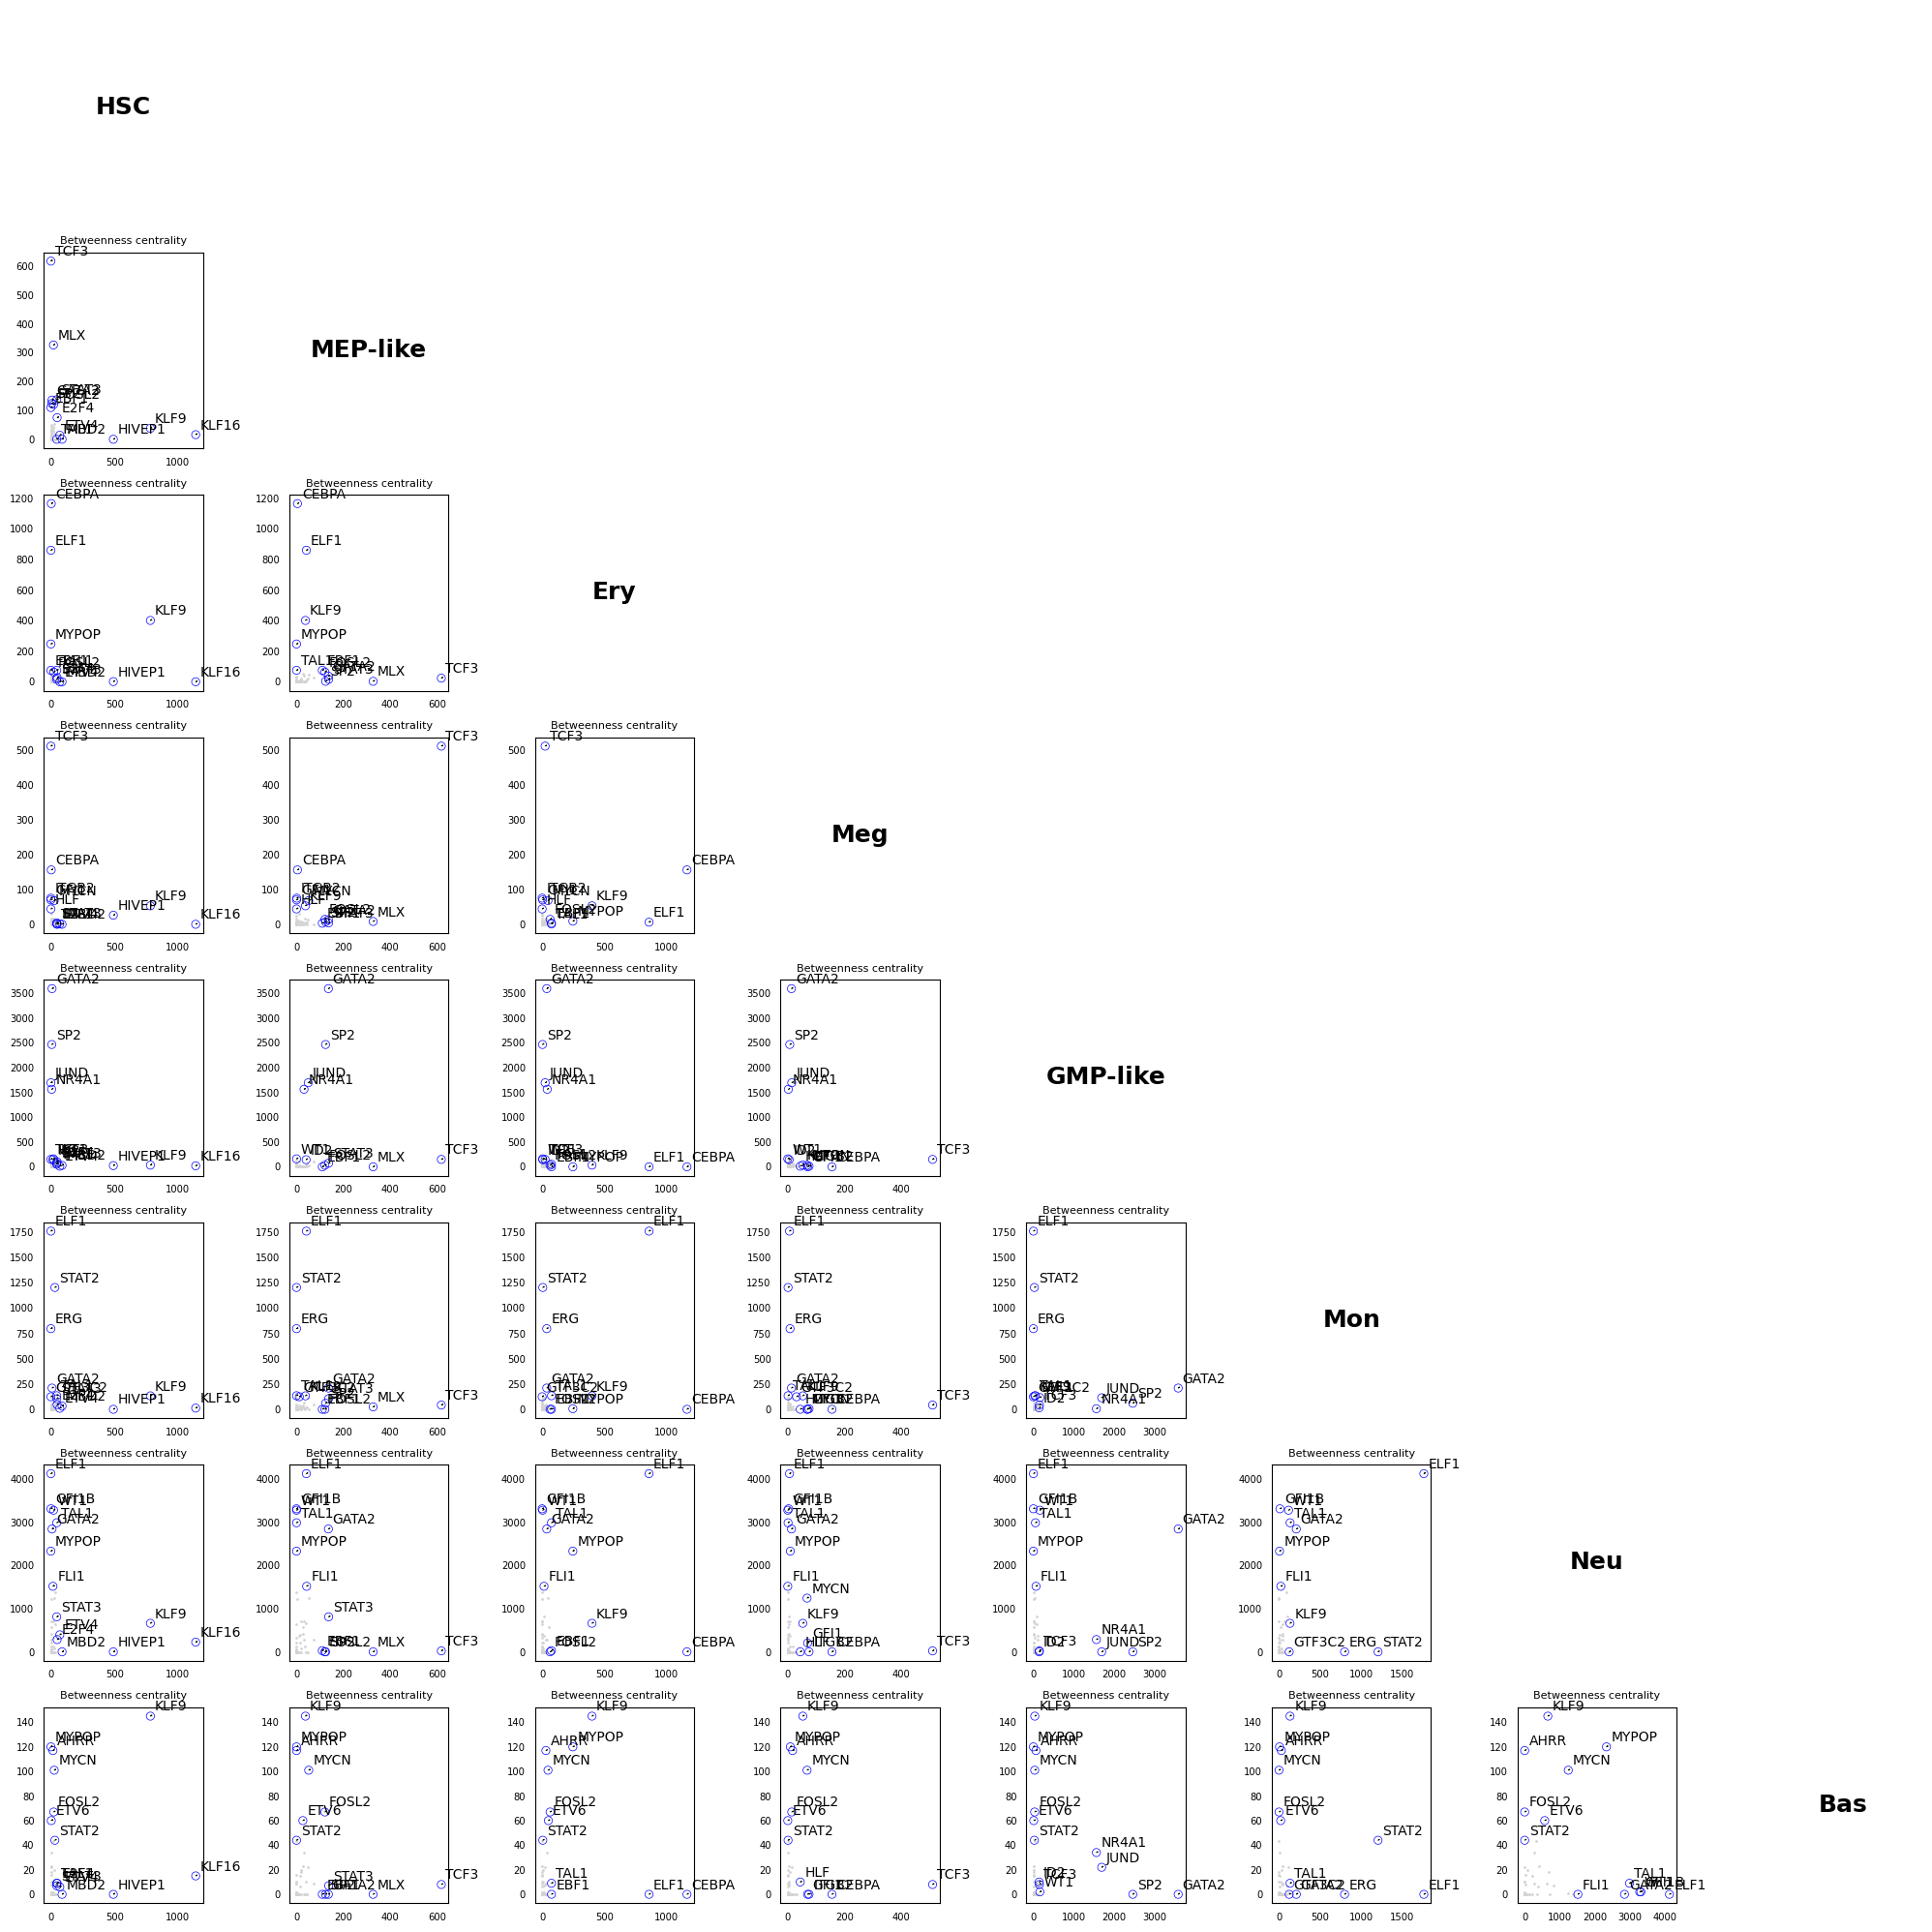

In [39]:
# ============================================================
# 4. Compare centrality between clusters (grid of comparisons)
# ============================================================
# This is similar to plot_score_comparison_grid but for one pair at a time
# You can create a grid manually or plot specific comparisons:
fig, axes = plt.subplots(len(CELL_TYPE_ORDER), len(CELL_TYPE_ORDER), figsize=(20, 20))

for i, clus1 in enumerate(CELL_TYPE_ORDER):
    for j, clus2 in enumerate(CELL_TYPE_ORDER):
        if i == j:
            # Diagonal: show cluster name
            axes[i, j].text(0.5, 0.5, clus1, ha='center', va='center',
                        fontsize=18, fontweight='bold',
                        transform=axes[i, j].transAxes)
            axes[i, j].axis('off')
        elif i < j:
            # Upper triangle: turn off
            axes[i, j].axis('off')
        else:
            # Lower triangle: plot comparison
            sch.pl.plot_centrality_comparison(
                adata,
                cluster1=CELL_TYPE_ORDER[j],
                cluster2=CELL_TYPE_ORDER[i],
                metric='betweenness_centrality',
                cluster_key=CLUSTER_KEY,
                percentile=99.6,
                annotate=True,
                ax=axes[i, j]
            )
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

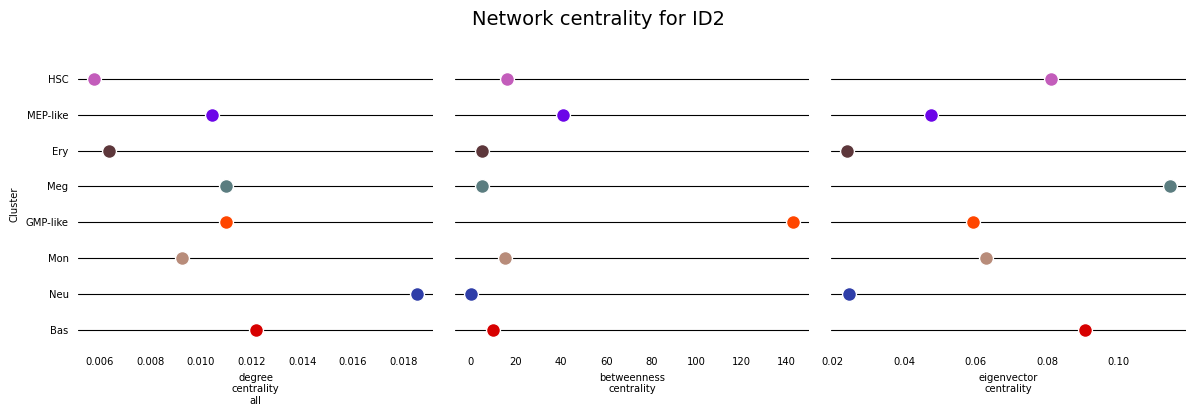

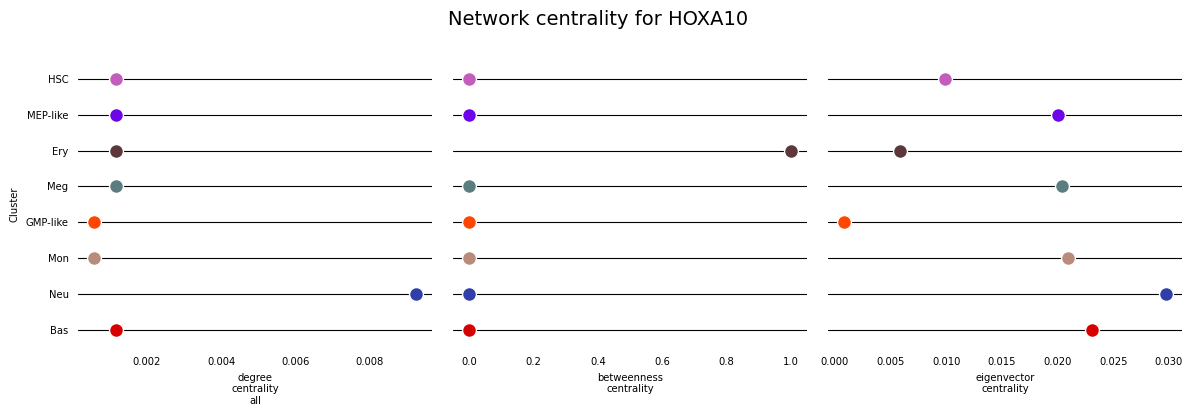

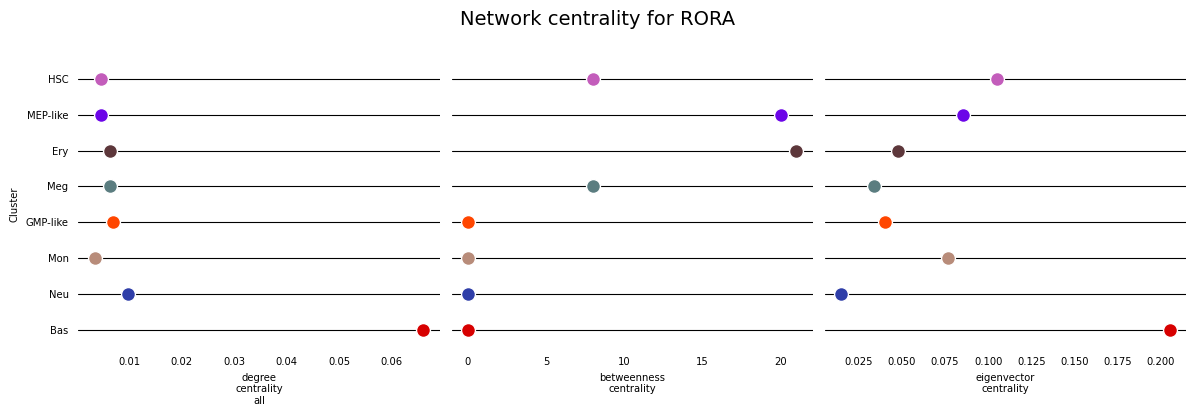

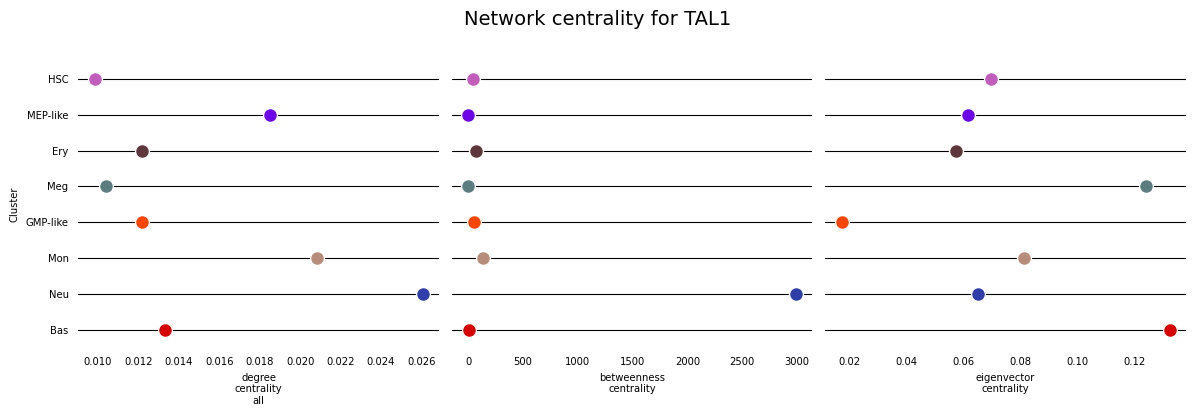

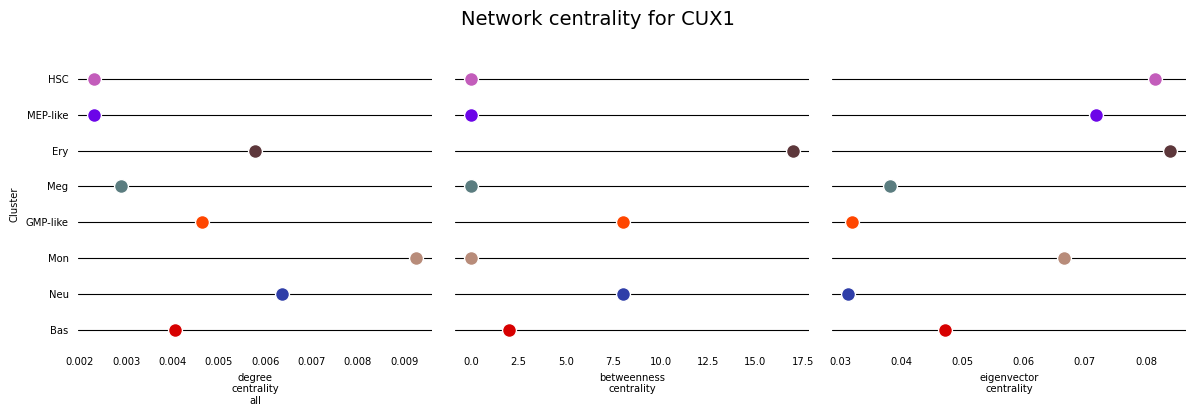

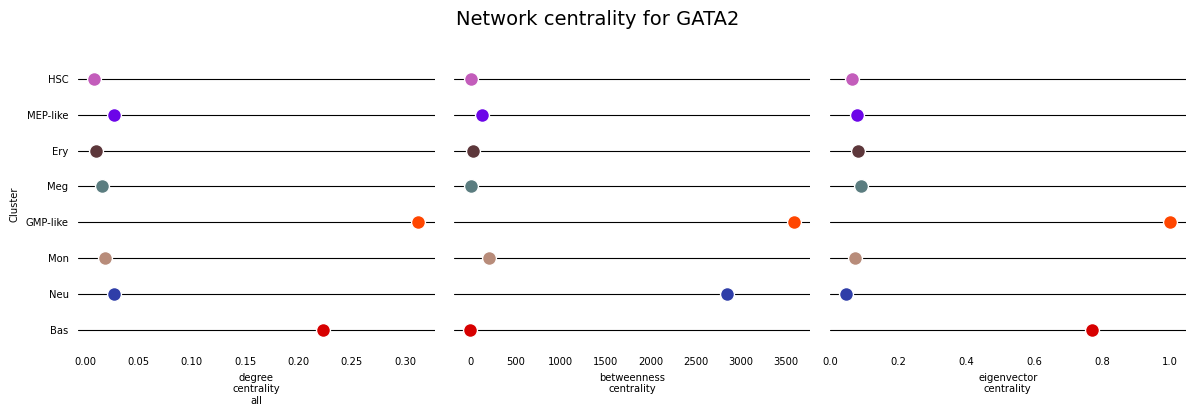

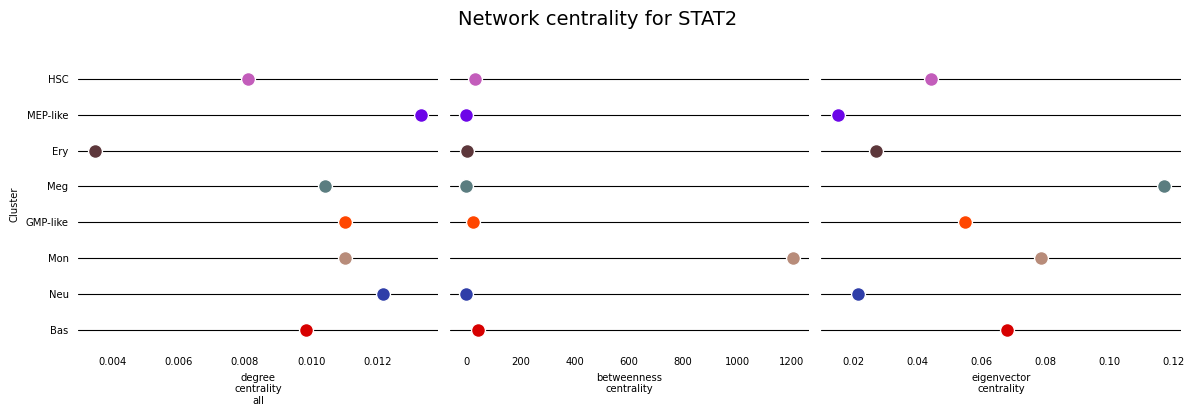

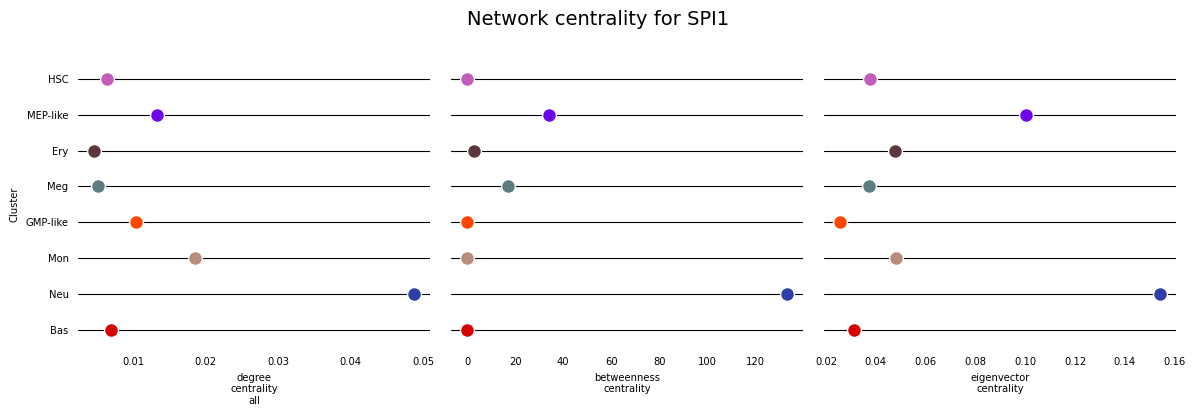

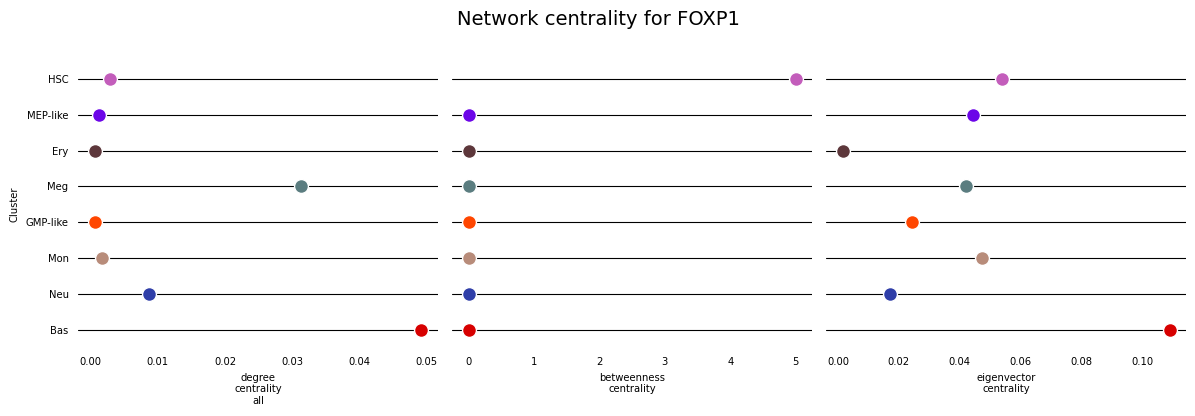

In [40]:
# ============================================================
# 5. Plot centrality for specific genes across clusters
# ============================================================
list_of_genes = ['ID2', 'HOXA10', 'RORA', 'TAL1', 'CUX1', 'GATA2',
                    'STAT2', 'SPI1', 'FOXP1']

for gene in list_of_genes:
    fig = sch.pl.plot_gene_centrality(
        adata,
        gene=gene,
        cluster_key=CLUSTER_KEY,
        order=CELL_TYPE_ORDER,
        colors=colors,
        figsize=(12, 4)
    )
    plt.show()

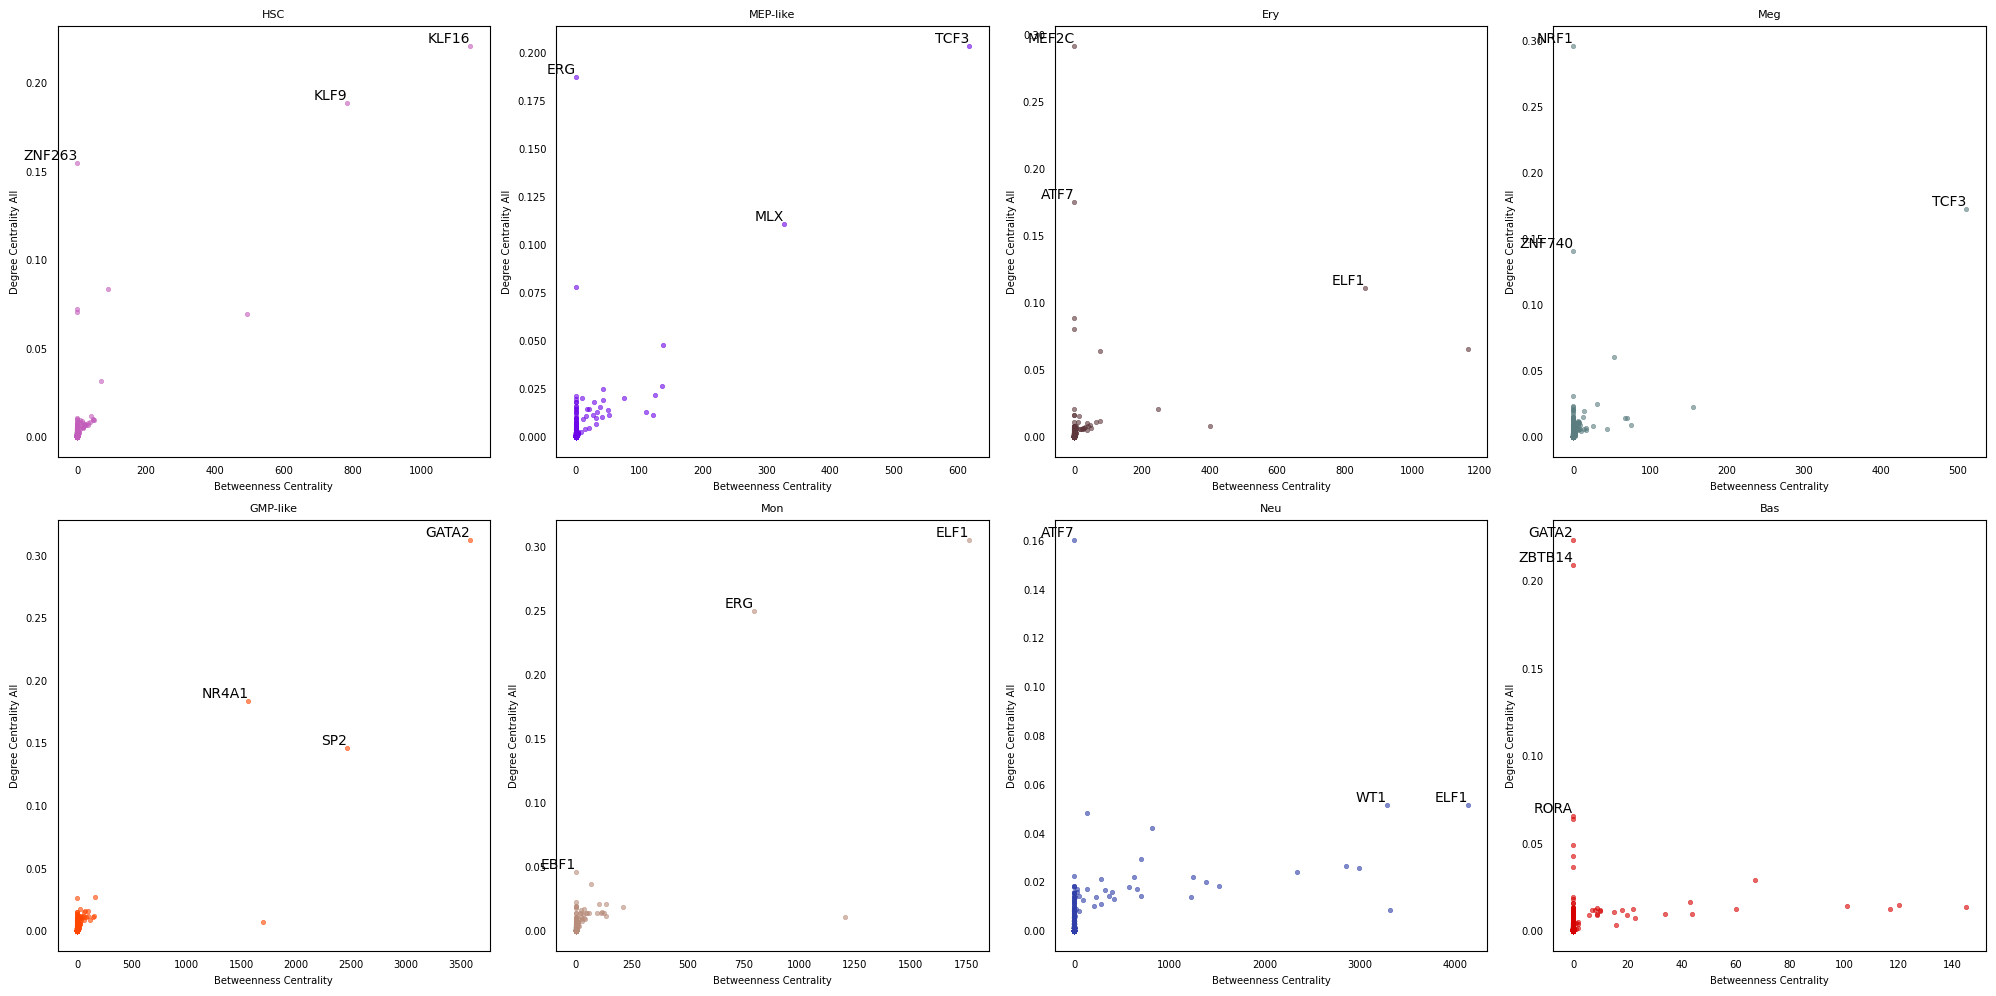

In [41]:
# ============================================================
# 6. Scatter plots: Betweenness vs Degree (high betweenness, low degree)
# ============================================================
fig = sch.pl.plot_centrality_scatter(
    adata,
    x_metric='betweenness_centrality',
    y_metric='degree_centrality_all',
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_top_genes=3,
    filter_threshold=('degree_centrality_all', '<', 0.5),  # Find high betweenness with low degree
    figsize=(20, 10)
)
plt.show()

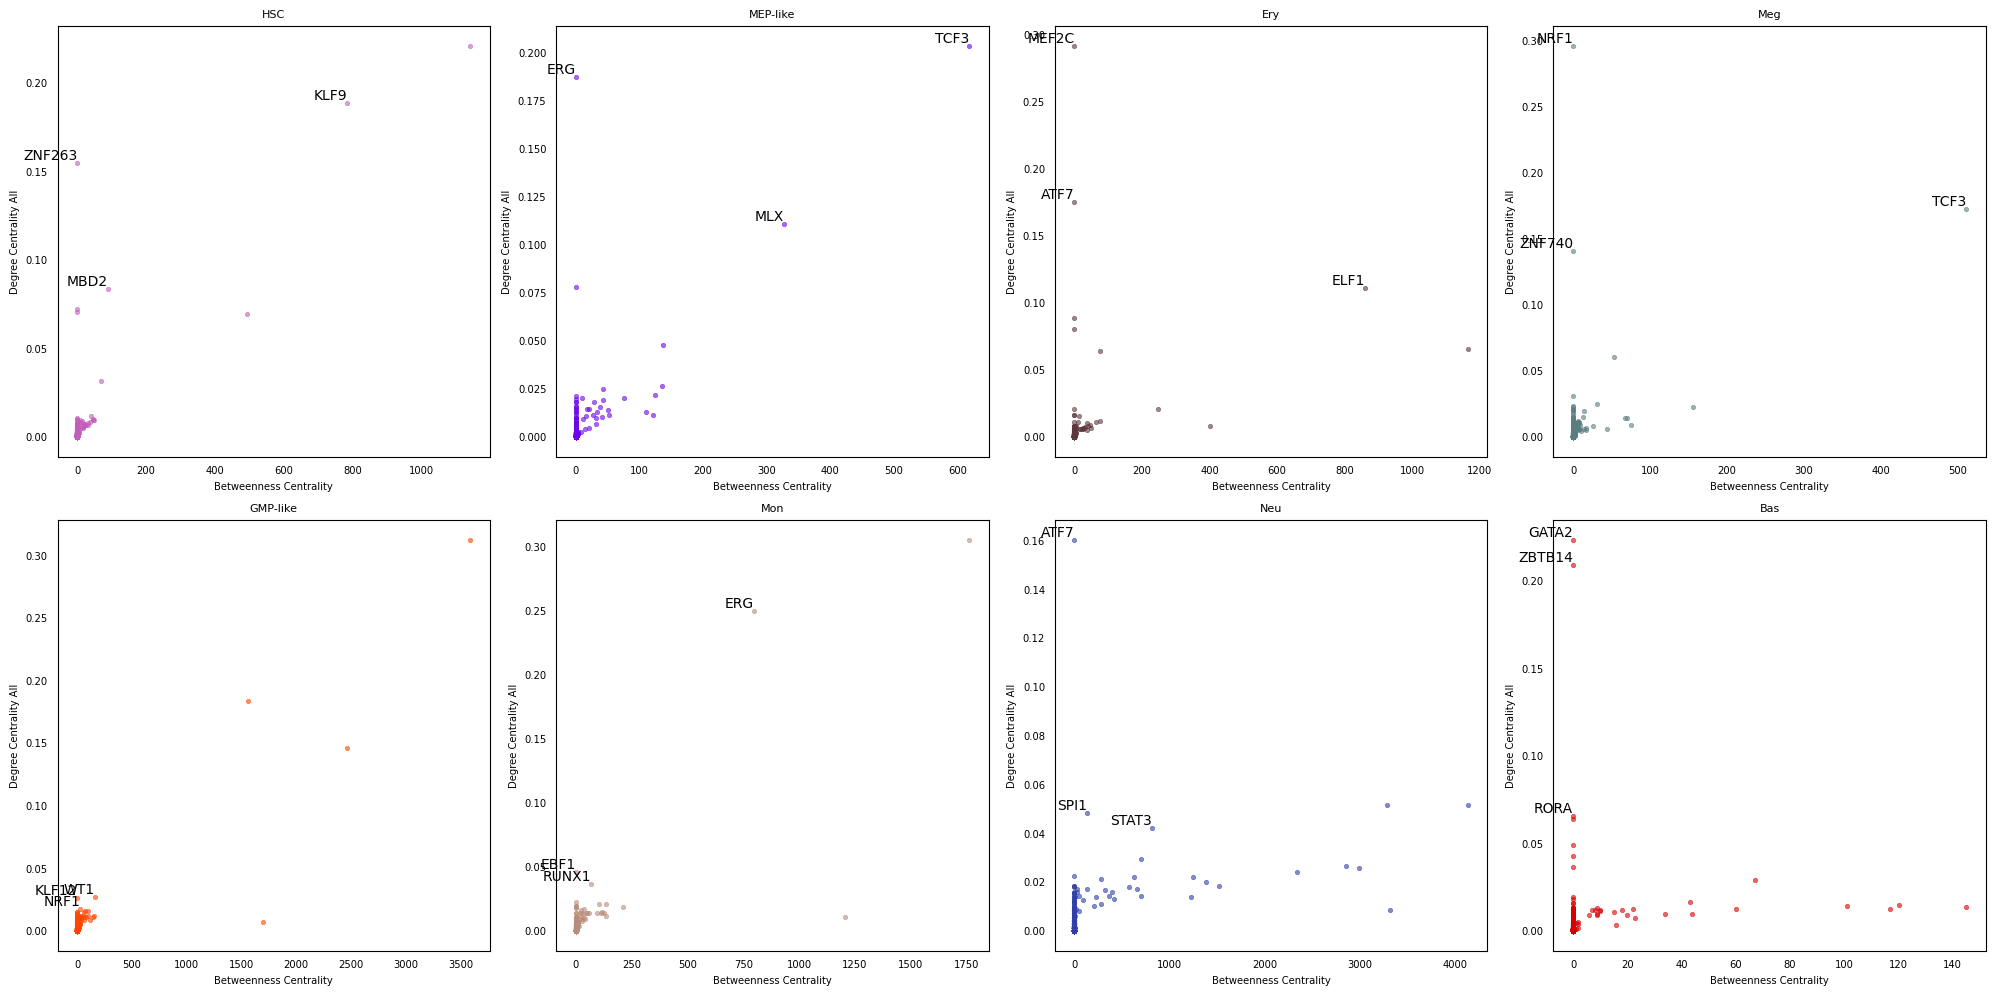

In [42]:
# ============================================================
# 7. Scatter plots: Betweenness vs Degree (high degree, low betweenness)
# ============================================================
fig = sch.pl.plot_centrality_scatter(
    adata,
    x_metric='betweenness_centrality',
    y_metric='degree_centrality_all',
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_top_genes=3,
    filter_threshold=('betweenness_centrality', '<', 1000),  # Find high degree with low betweenness
    figsize=(20, 10)
)
plt.show()

# Eigenvalues

## 1. Compute eigenanalysis for all clusters

In [ ]:
# ============================================================
# 1. Compute eigenanalysis for all clusters
# ============================================================
sch.tl.compute_eigenanalysis(adata, cluster_key=CLUSTER_KEY)

# 2. Plot comprehensive eigenanalysis grid

This creates a grid showing:
- Column 1: Eigenvalue spectrum in complex plane
- Column 2: Eigenvector for max eigenvalue (unstable direction)
- Column 3: Eigenvector for min eigenvalue (stable direction)

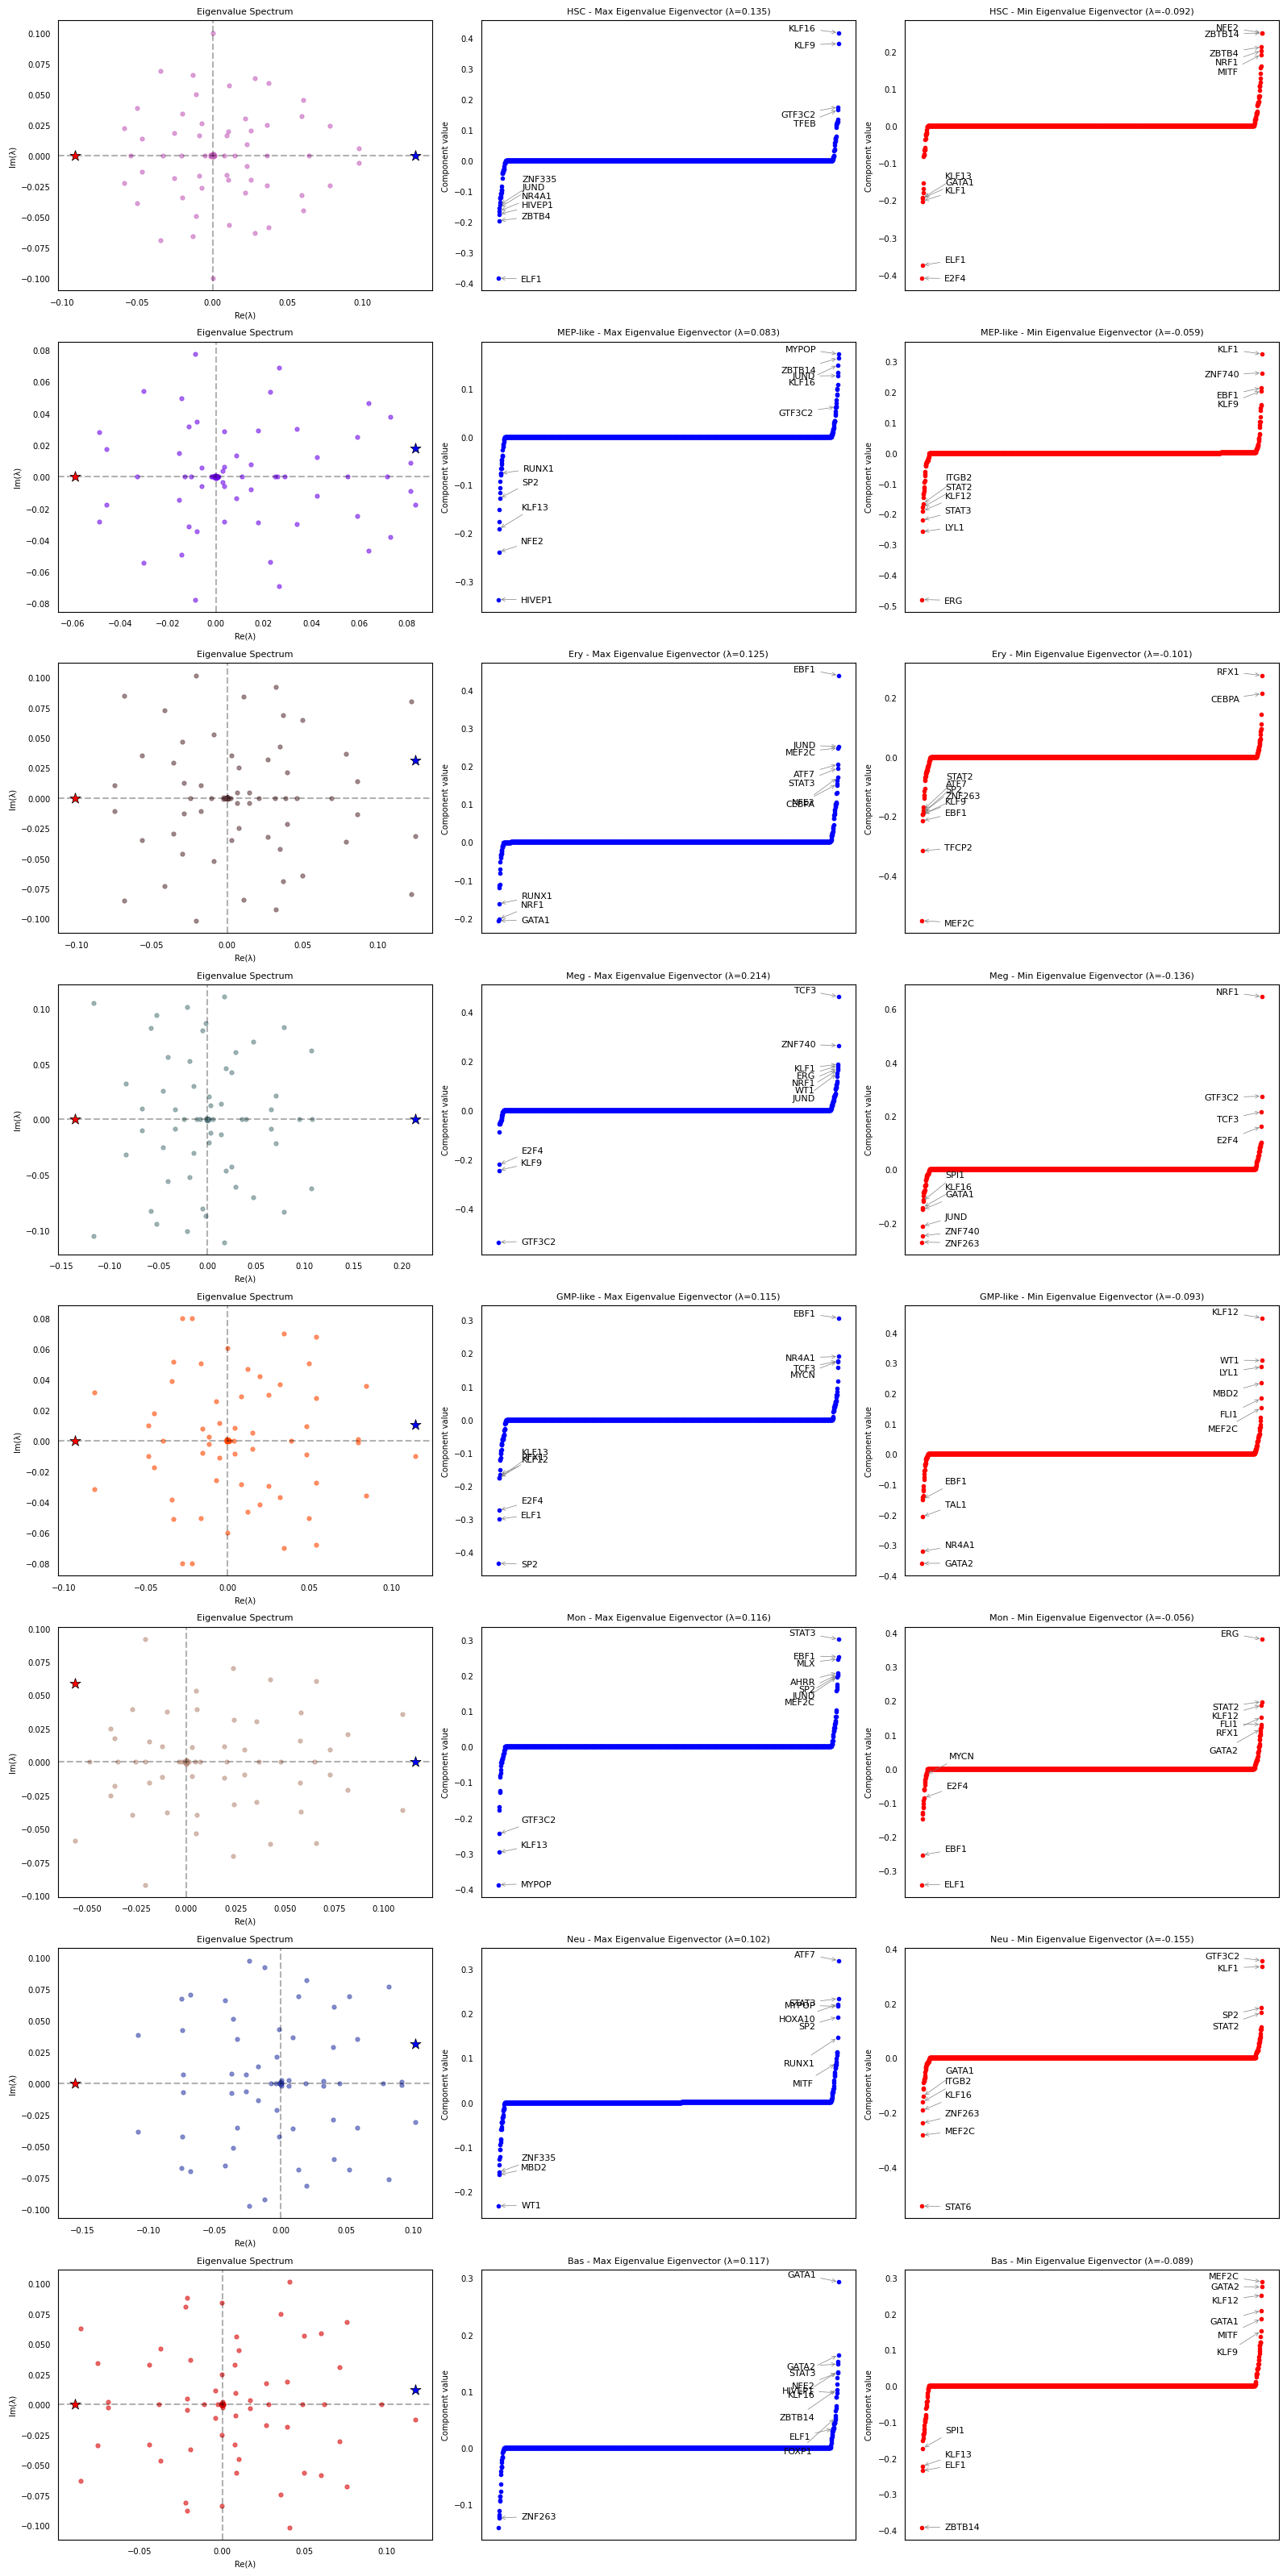

In [46]:
fig = sch.pl.plot_eigenanalysis_grid(
    adata,
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_genes=10,  # Number of top genes to annotate
    figsize=(16, 4 * len(CELL_TYPE_ORDER))
)
plt.show()

## 3. Get table of top genes from extreme eigenvectors

In [47]:
df_eigenanalysis = sch.tl.get_eigenanalysis_table(
    adata,
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER
)

# Display top 10 genes
print("Top genes from extreme eigenvectors:")
display(df_eigenanalysis.head(10))

Top genes from extreme eigenvectors:


HSC                              MEP-like                               \
  +EV gene +EV value -EV gene -EV value +EV gene +EV value -EV gene -EV value   
0    KLF16     0.418     E2F4    -0.409   HIVEP1    -0.338      ERG    -0.479   
1     ELF1    -0.384     ELF1    -0.374     NFE2    -0.239     KLF1     0.322   
2     KLF9     0.382     NFE2     0.250    KLF13    -0.191   ZNF740     0.260   
3    ZBTB4    -0.196   ZBTB14     0.249     FLI1    -0.177     LYL1    -0.258   
4   HIVEP1    -0.175    ZBTB4     0.212    MYPOP     0.172    STAT3    -0.220   
5   GTF3C2     0.175     KLF1    -0.202   ZBTB14     0.163     EBF1     0.212   
6     TFEB     0.165     NRF1     0.201    STAT3    -0.151     KLF9     0.202   
7    NR4A1    -0.165    GATA1    -0.194    KLF16     0.149    KLF12    -0.190   
8     JUND    -0.154    KLF13    -0.193    MEF2C     0.134    STAT2    -0.178   
9   ZNF335    -0.145     MITF     0.191      SP2    -0.128    ITGB2    -0.166   

       Ery            ...      Mon                Neu                     \
  +EV gene +EV value  ... -EV gene -EV value +EV gene +EV value -EV gene   
0     EBF1     0.440  ...      ERG     0.381     ATF7     0.319    STAT6   
1     JUND     0.252  ...     ELF1    -0.341      WT1    -0.233   GTF3C2   
2    MEF2C     0.248  ...     EBF1    -0.254    STAT3     0.233     KLF1   
3    GATA1    -0.207  ...    STAT2     0.197   HOXA10     0.221    MEF2C   
4     ATF7     0.205  ...    KLF12     0.187    MYPOP     0.216   ZNF263   
5     NRF1    -0.203  ...     RFX1     0.151      SP2     0.192    KLF16   
6    STAT3     0.195  ...     MBD2    -0.147     MBD2    -0.163      SP2   
7     NFE2     0.170  ...     ETV6    -0.132   ZNF335    -0.157    STAT2   
8     TAL1     0.163  ...     FLI1     0.130    RUNX1     0.145    ITGB2   
9    RUNX1    -0.162  ...     SPI1    -0.128     TAL1    -0.141    GATA1   

                 Bas                               
  -EV value +EV gene +EV value -EV gene -EV value  
0    -0.543    GATA1     0.293   ZBTB14    -0.392  
1     0.358    STAT3     0.164    MEF2C     0.288  
2     0.335     ETV6     0.153    GATA2     0.274  
3    -0.283    GATA2     0.148    KLF12     0.251  
4    -0.239     KLF9    -0.140     ELF1    -0.236  
5    -0.192    KLF16     0.134    KLF13    -0.222  
6     0.184     NFE2     0.132    GATA1     0.209  
7     0.166   ZNF263    -0.124     MITF     0.185  
8    -0.161     FLI1     0.124     SPI1    -0.173  
9    -0.141     LYL1    -0.121     KLF9     0.152  

[10 rows x 32 columns]

## 4. Plot individual eigenvalue spectra (optional)
Compare eigenvalue spectra across multiple clusters


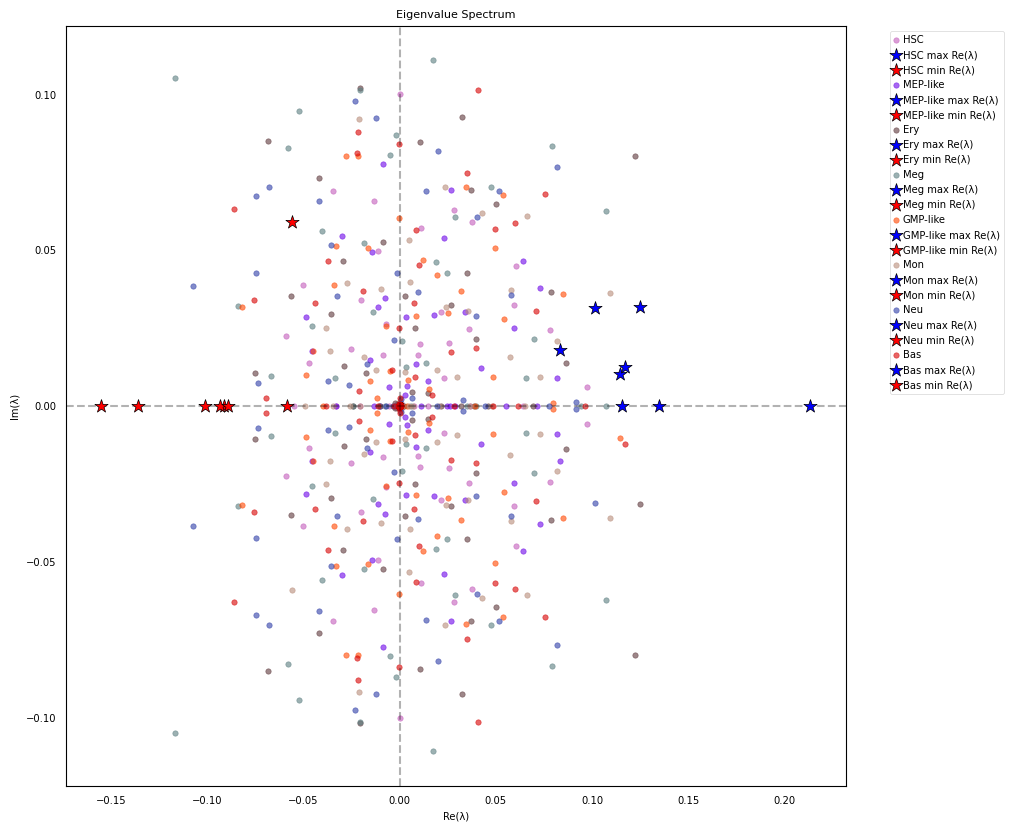

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
sch.pl.plot_eigenvalue_spectrum(
    adata,
    clusters=CELL_TYPE_ORDER,
    cluster_key=CLUSTER_KEY,
    colors=colors,
    highlight_extremes=True,
    ax=ax
)
plt.show()

## 5. Plot individual eigenvector components (optional)

Detailed view of eigenvector for a specific cluster

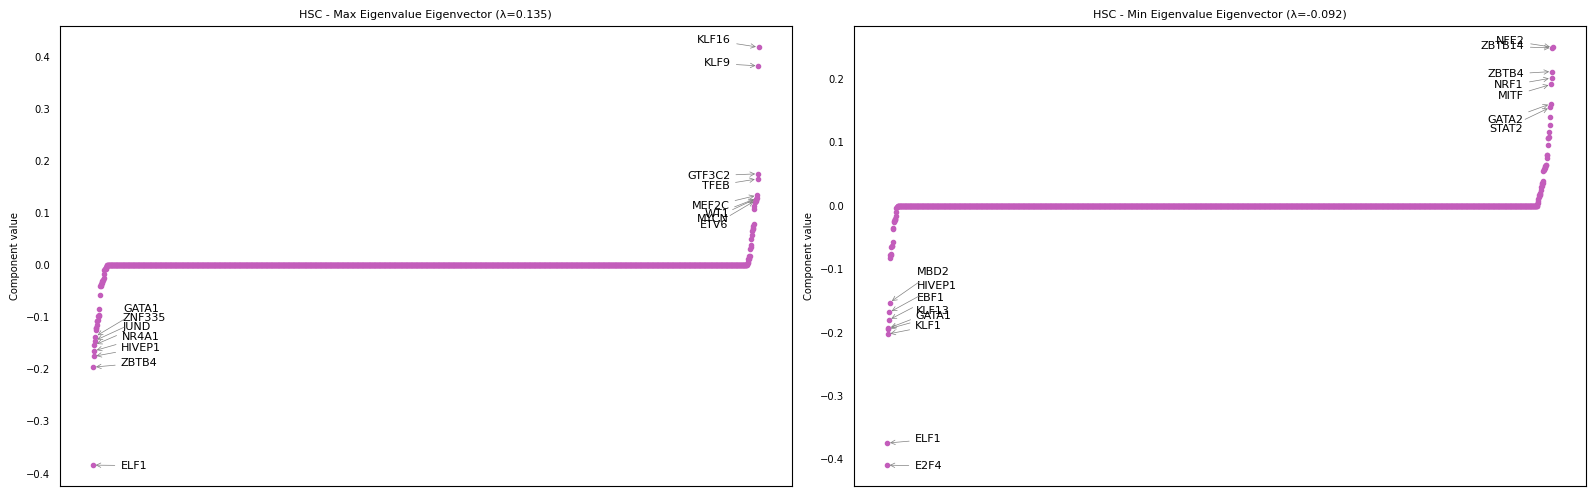

In [49]:
cluster_of_interest = 'HSC'

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Max eigenvalue eigenvector
sch.pl.plot_eigenvector_components(
    adata,
    cluster=cluster_of_interest,
    which='max',
    n_genes=15,
    cluster_key=CLUSTER_KEY,
    color=colors[cluster_of_interest],
    ax=axes[0]
)

# Min eigenvalue eigenvector
sch.pl.plot_eigenvector_components(
    adata,
    cluster=cluster_of_interest,
    which='min',
    n_genes=15,
    cluster_key=CLUSTER_KEY,
    color=colors[cluster_of_interest],
    ax=axes[1]
)

plt.tight_layout()
plt.show()

## 6. Get top genes for specific eigenvector (optional)

Get top genes from max eigenvalue eigenvector for HSC

In [50]:
df_top_genes_max = sch.tl.get_top_eigenvector_genes(
    adata,
    cluster='HSC',
    which='max',
    n_genes=20,
    part='real',
    cluster_key=CLUSTER_KEY
)

print(f"\nTop genes for HSC max eigenvalue eigenvector:")
print(f"Eigenvalue: {df_top_genes_max['eigenvalue'].iloc[0]}")
display(df_top_genes_max[['gene', 'component_value']])


Top genes for HSC max eigenvalue eigenvector:
Eigenvalue: (0.13495883345603943+0j)


gene  component_value
0    KLF16         0.417956
1     ELF1        -0.383839
2     KLF9         0.382159
3    ZBTB4        -0.195875
4   HIVEP1        -0.175206
5   GTF3C2         0.175108
6     TFEB         0.165311
7    NR4A1        -0.164668
8     JUND        -0.153559
9   ZNF335        -0.145091
10   GATA1        -0.137345
11   MEF2C         0.133914
12     WT1         0.128325
13    MYCN         0.127529
14    ETV6         0.124457
15    LYL1         0.123848
16    RFX1        -0.123714
17    TCF3         0.121757
18    NRF1        -0.121503
19   TFCP2        -0.121218

## 7. Print eigenvalue extremes for all clusters

In [52]:
print("\nExtreme eigenvalues per cluster:")
for cluster in CELL_TYPE_ORDER:
    eigenvalues = adata.uns['scHopfield']['eigenanalysis'][f'eigenvalues_{cluster}']
    max_eigenval = eigenvalues[np.argmax(eigenvalues.real)]
    min_eigenval = eigenvalues[np.argmin(eigenvalues.real)]

    print(f"{cluster:15s} | Max Re(λ): {max_eigenval.real:8.3f} | Min Re(λ): {min_eigenval.real:8.3f}")


Extreme eigenvalues per cluster:
HSC             | Max Re(λ):    0.135 | Min Re(λ):   -0.092
MEP-like        | Max Re(λ):    0.083 | Min Re(λ):   -0.059
Ery             | Max Re(λ):    0.125 | Min Re(λ):   -0.101
Meg             | Max Re(λ):    0.214 | Min Re(λ):   -0.136
GMP-like        | Max Re(λ):    0.115 | Min Re(λ):   -0.093
Mon             | Max Re(λ):    0.116 | Min Re(λ):   -0.056
Neu             | Max Re(λ):    0.102 | Min Re(λ):   -0.155
Bas             | Max Re(λ):    0.117 | Min Re(λ):   -0.089


# Jacobian

### Full Jacobian

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# === CONFIGURATION === #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Number of cells & genes
n_cells = ls.adata.n_obs
n_genes = len(ls.genes)

# Initialize Jacobians and Eigenvalues storage
jacobians = {
    'jacobians': np.zeros((n_cells, n_genes, n_genes)),
    'eigenvalues': np.zeros((n_cells, n_genes), dtype=np.complex128),
}

# === COMPUTE FULL JACOBIANS AND EIGENVALUES === #
for cluster_label, W_cluster in ls.W.items():
    if cluster_label == 'all':
        continue  # Skip general model

    print(f"Processing cluster: {cluster_label}")

    # Convert parameters to torch tensors on the correct device
    gamma = torch.diag(torch.tensor(ls.gamma[cluster_label], dtype=torch.float32, device=device))
    W = torch.tensor(W_cluster, dtype=torch.float32, device=device)
    
    # Select relevant cluster cells
    cluster_indices = np.where(ls.adata.obs[ls.cluster_key] == cluster_label)[0]
    cell_data = torch.tensor(ls.adata.layers[ls.spliced_matrix_key][cluster_indices][:, ls.genes].A, device=device)

    # Compute sigmoid derivative
    exponent = torch.tensor(ls.exponent, device=device)
    sigmoid_values = torch.tensor(ls.get_sigmoid(cell_data.cpu().numpy()), device=device)
    sigmoid_prime = exponent * sigmoid_values * (1 - sigmoid_values) / ((1 - cell_data) * (cell_data == 0) + cell_data)

    # Iterate through cells and compute Jacobians
    for idx, sig_prime_value in tqdm(
        zip(cluster_indices, sigmoid_prime),
        total=len(cluster_indices),
        desc=f"Computing Jacobians for {cluster_label}"
    ):
        jac_f = W * sig_prime_value[None, :] - gamma
        evals = torch.linalg.eigvals(jac_f)

        jacobians['jacobians'][idx] = jac_f.cpu().numpy()
        jacobians['eigenvalues'][idx] = evals.cpu().numpy()

In [ ]:
adata.layers['evals_full'] = scp.sparse.csr_matrix(adata.layers[ls.spliced_matrix_key].shape, dtype=np.complex128)
adata.layers['evals_full'][:,ls.genes] = jacobians['eigenvalues']

## Eigenvalue distribution of full Jacobian

In [ ]:
jac_full_evals = adata.layers['evals_full'].A
# fig,ax = plt.subplots(1,1,figsize=(15,5))
# ax.set_title('Eigenvalues of the Jacobian')
# for k in ls.W:
#     if k=='all':
#         continue
#     ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
# ax.legend()

# fig,axs = plt.subplots(2,4,figsize=(20,10), sharex=True, sharey=True, tight_layout=True)
# axs = axs.flatten()
# fig.suptitle('Real part of the eigenvalues of the Jacobian')
# for k,ax in zip(order, axs):
#     ax.set_title(k)
#     sns.histplot(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), ax=ax, color=colors[k], bins=100)
#     ax.set_yscale('log')
#     ax.text(0.1,0.9,f'Standard deviation\n{np.std(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten()):.2}', transform=ax.transAxes)

# plt.show()

In [ ]:
jac_full_evals = adata.layers['evals_full'].A
fig,axs = plt.subplots(4,2,figsize=(15,15), tight_layout=True, sharex=True, sharey=True)
ax.set_title('Eigenvalues of the Jacobian')
for k,ax in zip(ls.W,axs.flat):
    if k=='all':
        continue
    ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
    # ax.set_xlim(-20,None)
    ax.set_title(k)
plt.show()

Using device: cuda


NameError: name 'ls' is not defined

# First eigenvalues

## Full Jacobian

In [ ]:
def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

def plot_jacobian_eigenvalue(adata,jac_evals,n, fig_size=(17,5), name=''):
    adata.obs['eval_real_tmp'] = np.real(jac_evals[:,n])
    adata.obs['eval_imag_tmp'] = np.imag(jac_evals[:,n])
    adata.obs['eval_number_tmp'] = np.sum(np.real(jac_evals)>0, axis=1)
    adata.obs['eval_number_neg_tmp'] = np.sum(np.real(jac_evals)<0, axis=1)
    fig,axs = plt.subplots(1,3,figsize=fig_size)
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_real_tmp', ax=axs[0], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_imag_tmp', ax=axs[1], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_number_tmp', ax=axs[2], save_show_or_return='return')
    axs[0].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Real')
    axs[1].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Imaginary')
    axs[2].set_title(f'Number of positive eigenvalues\n{name.capitalize()} Jacobian - Real')
    plt.show()
    del adata.obs['eval_real_tmp'], adata.obs['eval_imag_tmp'], adata.obs['eval_number_tmp']

In [ ]:
np.abs(np.imag(jacobians['eigenvalues'])).shape

(1947, 1728)

In [ ]:
adata.obs['first_eval_full_real'] = np.real(jac_full_evals[:,0])
adata.obs['first_eval_full_imag'] = np.imag(jac_full_evals[:,0])
adata.obs['positive_evals_full_real'] = np.sum(np.real(jac_full_evals)>0, axis=1)
adata.obs['negative_evals_full_real'] = np.sum(np.real(jac_full_evals)<0, axis=1)
adata.obs['jacobian_trace'] = jacobians['jacobians'].trace(axis1=1, axis2=2)
A = 0.5*(jacobians['jacobians'] - jacobians['jacobians'].transpose(0,2,1))
adata.obs['rotational_part'] = np.linalg.norm(A, axis=(1,2))

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,15))
axs = axs.flatten()
# dyn.pl.streamline_plot(adata, color='first_eval_full_real', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
# dyn.pl.streamline_plot(adata, color='first_eval_full_imag', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='jacobian_trace', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='rotational_part', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='positive_evals_full_real', basis='umap', ax=axs[2], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='negative_evals_full_real', basis='umap', ax=axs[3], show_legend='on data', save_show_or_return='return')
axs[0].set_title('Trace of the Jacobian')
axs[1].set_title('Local rotational part of the Jacobian')
axs[2].set_title('Number of positive eigenvalues\n Jacobian - Real')
axs[3].set_title('Number of negative eigenvalues\n Jacobian - Real')
plt.show()

In [ ]:
plot_jacobian_eigenvalue(adata, jac_full_evals, 1)

## Distribution of positive eigenvalues

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])

In [ ]:
# --- Real Part ---
df_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)
df_real['cluster'] = adata.obs[cluster_key]
df_real = df_real.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_real = df_real[df_real['eigenvalue'] > 0]

# --- Imaginary Part ---
df_imag = pd.DataFrame(jac_full_evals[:, ls.genes].imag, index=adata.obs_names)
df_imag['cluster'] = adata.obs[cluster_key]
df_imag = df_imag.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_imag = df_imag[df_imag['eigenvalue'] > 0]

# --- Plot Setup ---
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharey=False, tight_layout=True)

# Real
sns.boxplot(
    data=df_real, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[0],
)
axs[0].set_title("Positive Real Part of Eigenvalues", fontsize=14)
axs[0].set_xlabel("Cluster", fontsize=12)
axs[0].set_ylabel("Eigenvalue (Real)", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.4)

# Imag
sns.boxplot(
    data=df_imag, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[1],
)
axs[1].set_title("Positive Imaginary Part of Eigenvalues", fontsize=14)
axs[1].set_xlabel("Cluster", fontsize=12)
axs[1].set_ylabel("Eigenvalue (Imaginary)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Distribution of number of positive eigenvalues

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])

In [ ]:
# Step 1: Compute the real part of all eigenvalues
df_evals_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)

# Step 2: Count positive eigenvalues per cell
pos_counts = (df_evals_real > 0).sum(axis=1)

# Step 3: Add cluster info
pos_counts = pos_counts.to_frame(name='positive_eigen_count')
pos_counts['cluster'] = adata.obs[cluster_key].values

# Step 4: Plot distribution
plt.figure(figsize=(15, 8))
sns.boxplot(data=pos_counts, x='cluster', y='positive_eigen_count', showfliers=True, order=order)
plt.ylabel("Number of Positive Real Eigenvalues")
plt.title("Distribution of Positive Eigenvalue Counts per Cell Type")
plt.tight_layout()
plt.show()

## Trace (divergence) and Vorticity

In [ ]:
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

In [ ]:
df_divergence_vorticity

jacobian_trace  rotational_part cell_type
barcode                                                       
CCACAAGCGTGC-JL12_0     -287.281633        12.800689       Mon
CCATCCTGTGGA-JL12_0     -295.101246        43.490254       Meg
CCCTCGGCCGCA-JL12_0     -288.236061        16.298562       Mon
CCGCCCACCATG-JL12_0     -283.560082        13.970761       Mon
CCGCTGTGTAAG-JL12_0     -293.742051         7.467204  MEP-like
...                             ...              ...       ...
GTGAACCTGTGA-JL12_1     -286.986476        12.901093  MEP-like
GTGAGACAATAC-JL12_1     -293.809392         6.929403  MEP-like
GTGATATTGACC-JL12_1     -295.050628         8.790370  MEP-like
GTGCCGCGACAA-JL12_1     -298.979089        17.625506       Bas
GTGTGCATTCCT-JL12_1     -293.738365        13.395640       Ery

[1947 rows x 3 columns]

In [ ]:
# Step 1: Compute the real part of all eigenvalues
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

# Step 4: Plot distribution
fig,axs = plt.subplots(2, 1, figsize=(15, 15))
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='jacobian_trace', showfliers=False, order=order, ax=axs[0])
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='rotational_part', showfliers=False, order=order, ax=axs[1])
axs[0].set_ylabel("Trace of the Jacobian")
axs[1].set_ylabel("Rotational part of the Jacobian")
axs[0].set_title("Distribution of Jacobian Trace per Cell Type")
axs[1].set_title("Distribution of Jacobian Rotational Part per Cell Type")
plt.tight_layout()
plt.show()

# Mean values

In [ ]:

def streamplot_eig_n(adata, eig_n, jacobian='diffusion', part='real', ax=None, **kwargs):
    figsize = kwargs.get('figsize',(15,10))
    cmap = kwargs.get('cmap','viridis')
    _,ax = plt.subplots(1, 1, figsize=figsize) if ax is None else (None,ax)
    part = np.real if part=='real' else np.imag
    adata.obs[f'Eigenvalue {eig_n+1}'] = part(adata.layers[f'evals_{jacobian}'][:,adata.var['use_for_dynamics'].values][:,eig_n].A.flatten())
    _ = dyn.pl.streamline_plot(adata, color=f'Eigenvalue {eig_n+1}', basis='umap', size=(15,10), show_legend='on data', cmap=cmap, show_arrowed_spines=True, ax=ax, save_show_or_return='return')
    # plt.show()
    del adata.obs[f'Eigenvalue {eig_n+1}']

In [ ]:

fig,axs = plt.subplots(5,4,figsize=(15,15))
for i,ax in enumerate(axs.flatten()):
    streamplot_eig_n(adata, i, jacobian='full', cmap='coolwarm', ax=ax)
plt.show()

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# === CONFIGURATION === #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Number of cells & genes
n_cells = ls.adata.n_obs
n_genes = len(ls.genes)

# Initialize Jacobians and Eigenvalues storage
jacobians = {
    'jacobians': np.zeros((n_cells, n_genes, n_genes)),
    'eigenvalues': np.zeros((n_cells, n_genes), dtype=np.complex128),
}

# === COMPUTE FULL JACOBIANS AND EIGENVALUES === #
for cluster_label, W_cluster in ls.W.items():
    if cluster_label == 'all':
        continue  # Skip general model

    print(f"Processing cluster: {cluster_label}")

    # Convert parameters to torch tensors on the correct device
    gamma = torch.diag(torch.tensor(ls.gamma[cluster_label], dtype=torch.float32, device=device))
    W = torch.tensor(W_cluster, dtype=torch.float32, device=device)
    
    # Select relevant cluster cells
    cluster_indices = np.where(ls.adata.obs[ls.cluster_key] == cluster_label)[0]
    cell_data = torch.tensor(ls.adata.layers[ls.spliced_matrix_key][cluster_indices][:, ls.genes].A, device=device)

    # Compute sigmoid derivative
    exponent = torch.tensor(ls.exponent, device=device)
    sigmoid_values = torch.tensor(ls.get_sigmoid(cell_data.cpu().numpy()), device=device)
    sigmoid_prime = exponent * sigmoid_values * (1 - sigmoid_values) / ((1 - cell_data) * (cell_data == 0) + cell_data)

    # Iterate through cells and compute Jacobians
    for idx, sig_prime_value in tqdm(
        zip(cluster_indices, sigmoid_prime),
        total=len(cluster_indices),
        desc=f"Computing Jacobians for {cluster_label}"
    ):
        jac_f = W * sig_prime_value[None, :] - gamma
        evals = torch.linalg.eigvals(jac_f)

        jacobians['jacobians'][idx] = jac_f.cpu().numpy()
        jacobians['eigenvalues'][idx] = evals.cpu().numpy()
        
adata.layers['evals_full'] = scp.sparse.csr_matrix(adata.layers[ls.spliced_matrix_key].shape, dtype=np.complex128)
adata.layers['evals_full'][:,ls.genes] = jacobians['eigenvalues']

jac_full_evals = adata.layers['evals_full'].A
fig,axs = plt.subplots(4,2,figsize=(15,15), tight_layout=True, sharex=True, sharey=True)
ax.set_title('Eigenvalues of the Jacobian')
for k,ax in zip(ls.W,axs.flat):
    if k=='all':
        continue
    ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
    # ax.set_xlim(-20,None)
    ax.set_title(k)
plt.show()

def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

def plot_jacobian_eigenvalue(adata,jac_evals,n, fig_size=(17,5), name=''):
    adata.obs['eval_real_tmp'] = np.real(jac_evals[:,n])
    adata.obs['eval_imag_tmp'] = np.imag(jac_evals[:,n])
    adata.obs['eval_number_tmp'] = np.sum(np.real(jac_evals)>0, axis=1)
    adata.obs['eval_number_neg_tmp'] = np.sum(np.real(jac_evals)<0, axis=1)
    fig,axs = plt.subplots(1,3,figsize=fig_size)
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_real_tmp', ax=axs[0], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_imag_tmp', ax=axs[1], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_number_tmp', ax=axs[2], save_show_or_return='return')
    axs[0].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Real')
    axs[1].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Imaginary')
    axs[2].set_title(f'Number of positive eigenvalues\n{name.capitalize()} Jacobian - Real')
    plt.show()
    del adata.obs['eval_real_tmp'], adata.obs['eval_imag_tmp'], adata.obs['eval_number_tmp']

adata.obs['first_eval_full_real'] = np.real(jac_full_evals[:,0])
adata.obs['first_eval_full_imag'] = np.imag(jac_full_evals[:,0])
adata.obs['positive_evals_full_real'] = np.sum(np.real(jac_full_evals)>0, axis=1)
adata.obs['negative_evals_full_real'] = np.sum(np.real(jac_full_evals)<0, axis=1)
adata.obs['jacobian_trace'] = jacobians['jacobians'].trace(axis1=1, axis2=2)
A = 0.5*(jacobians['jacobians'] - jacobians['jacobians'].transpose(0,2,1))
adata.obs['rotational_part'] = np.linalg.norm(A, axis=(1,2))

fig,axs = plt.subplots(2,2,figsize=(20,15))
axs = axs.flatten()
# dyn.pl.streamline_plot(adata, color='first_eval_full_real', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
# dyn.pl.streamline_plot(adata, color='first_eval_full_imag', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='jacobian_trace', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='rotational_part', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='positive_evals_full_real', basis='umap', ax=axs[2], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='negative_evals_full_real', basis='umap', ax=axs[3], show_legend='on data', save_show_or_return='return')
axs[0].set_title('Trace of the Jacobian')
axs[1].set_title('Local rotational part of the Jacobian')
axs[2].set_title('Number of positive eigenvalues\n Jacobian - Real')
axs[3].set_title('Number of negative eigenvalues\n Jacobian - Real')
plt.show()
plot_jacobian_eigenvalue(adata, jac_full_evals, 1)

# --- Real Part ---
df_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)
df_real['cluster'] = adata.obs[cluster_key]
df_real = df_real.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_real = df_real[df_real['eigenvalue'] > 0]

# --- Imaginary Part ---
df_imag = pd.DataFrame(jac_full_evals[:, ls.genes].imag, index=adata.obs_names)
df_imag['cluster'] = adata.obs[cluster_key]
df_imag = df_imag.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_imag = df_imag[df_imag['eigenvalue'] > 0]

# --- Plot Setup ---
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharey=False, tight_layout=True)

# Real
sns.boxplot(
    data=df_real, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[0],
)
axs[0].set_title("Positive Real Part of Eigenvalues", fontsize=14)
axs[0].set_xlabel("Cluster", fontsize=12)
axs[0].set_ylabel("Eigenvalue (Real)", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.4)

# Imag
sns.boxplot(
    data=df_imag, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[1],
)
axs[1].set_title("Positive Imaginary Part of Eigenvalues", fontsize=14)
axs[1].set_xlabel("Cluster", fontsize=12)
axs[1].set_ylabel("Eigenvalue (Imaginary)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Step 1: Compute the real part of all eigenvalues
df_evals_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)

# Step 2: Count positive eigenvalues per cell
pos_counts = (df_evals_real > 0).sum(axis=1)

# Step 3: Add cluster info
pos_counts = pos_counts.to_frame(name='positive_eigen_count')
pos_counts['cluster'] = adata.obs[cluster_key].values

# Step 4: Plot distribution
plt.figure(figsize=(15, 8))
sns.boxplot(data=pos_counts, x='cluster', y='positive_eigen_count', showfliers=True, order=order)
plt.ylabel("Number of Positive Real Eigenvalues")
plt.title("Distribution of Positive Eigenvalue Counts per Cell Type")
plt.tight_layout()
plt.show()

df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

# Step 1: Compute the real part of all eigenvalues
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

# Step 4: Plot distribution
fig,axs = plt.subplots(2, 1, figsize=(15, 15))
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='jacobian_trace', showfliers=False, order=order, ax=axs[0])
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='rotational_part', showfliers=False, order=order, ax=axs[1])
axs[0].set_ylabel("Trace of the Jacobian")
axs[1].set_ylabel("Rotational part of the Jacobian")
axs[0].set_title("Distribution of Jacobian Trace per Cell Type")
axs[1].set_title("Distribution of Jacobian Rotational Part per Cell Type")
plt.tight_layout()
plt.show()

def streamplot_eig_n(adata, eig_n, jacobian='diffusion', part='real', ax=None, **kwargs):
    figsize = kwargs.get('figsize',(15,10))
    cmap = kwargs.get('cmap','viridis')
    _,ax = plt.subplots(1, 1, figsize=figsize) if ax is None else (None,ax)
    part = np.real if part=='real' else np.imag
    adata.obs[f'Eigenvalue {eig_n+1}'] = part(adata.layers[f'evals_{jacobian}'][:,adata.var['use_for_dynamics'].values][:,eig_n].A.flatten())
    _ = dyn.pl.streamline_plot(adata, color=f'Eigenvalue {eig_n+1}', basis='umap', size=(15,10), show_legend='on data', cmap=cmap, show_arrowed_spines=True, ax=ax, save_show_or_return='return')
    # plt.show()
    del adata.obs[f'Eigenvalue {eig_n+1}']

fig,axs = plt.subplots(5,4,figsize=(15,15))
for i,ax in enumerate(axs.flatten()):
    streamplot_eig_n(adata, i, jacobian='full', cmap='coolwarm', ax=ax)
plt.show()

## Dynamo figure

In [ ]:
index_gata1 = ls.adata.var.index.get_indexer_for(['GATA1'])[0]
index_gata2 = ls.adata.var.index.get_indexer_for(['GATA2'])[0]
index_fli1 = ls.adata.var.index.get_indexer_for(['FLI1'])[0]
index_cebpa = ls.adata.var.index.get_indexer_for(['CEBPA'])[0]
index_runx1 = ls.adata.var.index.get_indexer_for(['RUNX1'])[0]
index_klf1 = ls.adata.var.index.get_indexer_for(['KLF1'])[0]



## Jacobians clustered

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$'] = jacobians['jacobians'][:,index_fli1,index_klf1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_klf1,index_fli1]
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_fli1,index_fli1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}$'] = jacobians['jacobians'][:,index_klf1,index_klf1]

ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_gata1,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_gata2,index_gata1]
ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{KLF1}}$'] = jacobians['jacobians'][:,index_gata1,index_klf1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_klf1,index_gata1]
ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_gata1,index_fli1]
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_fli1,index_gata1]

ls.adata.obs[r'$\frac{df_{CEBPA}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_cebpa,index_runx1]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{CEBPA}}$'] = jacobians['jacobians'][:,index_runx1,index_cebpa]
ls.adata.obs[r'$\frac{df_{CEBPA}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_cebpa,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{CEBPA}}$'] = jacobians['jacobians'][:,index_gata2,index_cebpa]

ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_gata2,index_runx1]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_runx1,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_gata2,index_gata2]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_runx1,index_runx1] 

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
# plt.delaxes(axs[1,1])

fig,axs = plt.subplots(2,3,figsize=(15,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,2], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,2], sym_c=True)

fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{CEBPA}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{CEBPA}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{CEBPA}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{CEBPA}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)

fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='show', ax=axs[1,1], sym_c=True)

# Networks with prevalent genes

## Code

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, LinearSegmentedColormap

def GRN_graph(
    ls, W1, genes, merged_scores, 
    score_size=None, size_threshold=0, score_color=None, cmap=None,  
    topn=None, ax=None, w_quantile=0.99
):
    """
    Generates a Gene Regulatory Network (GRN) graph.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        genes (list): List of gene names.
        merged_scores (pd.DataFrame): Dataframe containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        size_threshold (float, optional): Threshold for displaying node labels. Defaults to 0.
        score_color (str, optional): Not currently used. Defaults to None.
        cmap (str or Colormap, optional): Colormap for edge coloring. Defaults to None.
        topn (int, optional): Number of top genes to retain based on size. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        w_quantile (float, optional): Quantile threshold for filtering weak edges. Defaults to 0.99.

    Returns:
        None: Displays a network plot.
    """

    # Copy matrix to avoid modifying original data
    W = W1.copy()
    
    # Threshold edges based on weight quantile
    threshold = np.quantile(abs(W), w_quantile)
    W[abs(W) < threshold] = 0

    # Create DataFrame representation
    df = pd.DataFrame(W, index=ls.gene_names, columns=ls.gene_names).T

    # Compute node sizes
    if score_size is None:
        sizes = abs(W).sum(axis=0) + abs(W).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in df.index
        ])

    # Filter top genes based on size
    topq = np.sort(sizes)[-topn] if topn is not None else 0
    dropids = df.index[sizes < topq]
    
    # Normalize sizes for better visualization
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = sizes[ls.gene_names.isin(genes)]
    sizes = size_multiplier * sizes[sizes >= topq]
    
    # Remove genes below threshold
    genes = [g for g in genes if g not in dropids]
    df.drop(index=dropids, columns=dropids, inplace=True)
    df = df[genes].loc[genes]

    # Define node labels (hide small ones)
    labels = {
        gene: gene if size / 1000 > size_threshold else ''
        for gene, size in zip(df.index, sizes)
    }

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)
    Gp = nx.from_pandas_adjacency(abs(df), create_using=nx.DiGraph)

    # Compute edge weights for visualization
    weights = np.array([abs(G[u][v]['weight']) for u, v in G.edges()])
    weights_signed = 10 * np.array([G[u][v]['weight'] for u, v in G.edges()])
    weights = 1.5 * np.log(1 + weights) / np.log(1 + max(weights)) if weights.size else weights

    # Define node positions
    pos = nx.circular_layout(G)  # Alternative: nx.spring_layout(Gp), nx.kamada_kawai_layout(Gp)

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Validate colormap input
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap) if cmap is not None else plt.cm.viridis
    elif not isinstance(cmap, Colormap):
        raise ValueError("`cmap` must be a string or a matplotlib.colors.Colormap instance")

    # Compute colormap normalization
    vmax = max(weights) if weights.size else 1

    # Draw network graph
    nx.draw_networkx(
        G, pos, node_size=sizes, width=weights, with_labels=True, labels=labels,
        edge_color=weights_signed, edge_cmap=cmap, edge_vmin=-vmax, edge_vmax=vmax, ax=ax
    )

    plt.tight_layout()

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_subset_grn(
    ls, W1, selected_genes, merged_scores, 
    score_size=None, ax=None, node_positions=None,
    prune_threshold=0, selected_edges=None, 
    node_color='white', label_offset=0.11, label_size=12,
    variable_width = False,
):
    """
    Plots a Gene Regulatory Network (GRN) for a user-defined subset of genes.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        selected_genes (list): List of genes to include in the graph.
        merged_scores (pd.DataFrame): DataFrame containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        node_positions (dict, optional): Dictionary with custom node positions.
        prune_threshold (float, optional): Edges below this threshold (absolute value) will be removed.
        selected_edges (list of tuples, optional): List of user-defined edges (tuples) to plot.
        node_color (str, optional): Color of nodes. Default is `"skyblue"`.
        label_offset (float, optional): Distance of labels from nodes. Default is `0.15`.
        label_size (int, optional): Font size for labels. Default is `12`.

    Returns:
        None: Displays a network plot.
    """

    # Convert adjacency matrix to DataFrame
    df = pd.DataFrame(W1, index=ls.gene_names, columns=ls.gene_names).T

    # Subset the graph to only the selected nodes
    df = df.loc[selected_genes, selected_genes]

    # **Prune weak edges**
    df[abs(df) < prune_threshold] = 0  

    # **Filter only user-defined edges (if provided)**
    if selected_edges:
        mask = np.zeros_like(df, dtype=bool)
        for u, v in selected_edges:
            if u in df.index and v in df.columns:
                mask[df.index.get_loc(u), df.columns.get_loc(v)] = True
        df[~mask] = 0  # Keep only selected edges

    # Compute node sizes
    if score_size is None:
        sizes = abs(df).sum(axis=0) + abs(df).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in selected_genes
        ])

    # Normalize sizes
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = size_multiplier * sizes
    node_size_dict = {node: size for node, size in zip(selected_genes, sizes)}

    # Define node labels
    labels = {gene: gene for gene in selected_genes}

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

    # Compute edge weights
    edge_list = [(u, v) for u, v in G.edges() if abs(G[u][v]['weight']) >= prune_threshold]
    weights = np.array([abs(G[u][v]['weight']) for u, v in edge_list])
    weights_signed = np.array([G[u][v]['weight'] for u, v in edge_list])

    # Normalize edge widths
    weights = 2 * np.log1p(weights) / np.log1p(weights.max()) if weights.size else weights

    # Use predefined node positions if provided, otherwise default to spring layout
    pos = {gene: node_positions[gene] for gene in selected_genes if gene in node_positions} if node_positions else {}
    if len(pos) < len(selected_genes):
        default_layout = nx.spring_layout(G)
        for node in selected_genes:
            if node not in pos:
                pos[node] = default_layout[node]

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Set fixed edge colors (Red for positive, Blue for negative)
    edge_colors = ['red' if w > 0 else 'blue' for w in weights_signed]

    # Handle bidirectional edges: shift arcs slightly to avoid overlap
    curved_edges = set()
    for u, v in edge_list:
        if u == v:
            continue
        if (v, u) in edge_list and (v, u) not in curved_edges:
            curved_edges.add((u, v))
            curved_edges.add((v, u))

    # # **Calculate dynamic arrow size based on node size**
    # min_arrow_size = 15
    # max_arrow_size = 35
    # arrow_sizes = np.clip(weights * 10, min_arrow_size, max_arrow_size)

    # **Adjust margins for each node**
    min_margin = 0.02
    max_margin = 0.1
    node_margins = {node: np.clip(size / 2000, min_margin, max_margin) for node, size in node_size_dict.items()}

    # **First, draw edges BELOW nodes (background)**
    # nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=weights, edge_color=edge_colors, 
    #                        ax=ax, alpha=0.4, connectionstyle="arc3,rad=0.1")

    # **Then, draw nodes (foreground)**
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_color, edgecolors='black', linewidths=1.5, ax=ax, alpha=0.9)

    # **Move labels outside the nodes**
    adjusted_pos = {k: (v[0], v[1] + label_offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, adjusted_pos, labels, font_size=label_size, ax=ax)

    # **Finally, draw edges ABOVE nodes with adjusted arrows**
    for edge in edge_list:
        u, v = edge
        edge_idx = edge_list.index(edge)
        width = weights[edge_idx] if variable_width else 1
        style = "arc3,rad=0.15" if edge in curved_edges else "arc3,rad=0"
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width,
                               edge_color=[edge_colors[edge_idx]], ax=ax, 
                               arrows=True, #arrowsize=arrow_sizes[edge_idx], 
                               min_source_margin=node_margins.get(u, min_margin), 
                               min_target_margin=node_margins.get(v, min_margin), 
                               connectionstyle=style)

    plt.tight_layout()

## Figure from Networks

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, ls.W[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## Figure from Jacobian

In [ ]:
jacobians['jacobians'].shape

(1947, 1728, 1728)

In [ ]:
mean_jacobian = {}
for k in order:
    cell_idx = np.where(adata.obs[cluster_key] == k)[0]
    mean_jacobian[k] = np.mean(jacobians['jacobians'][cell_idx], axis=0)

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, mean_jacobian[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=None, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, mean_jacobian[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=None, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## FLI1 - KLF1 exploration

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dyn.pl.scatters(ls.adata, color='FLI1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[0], sym_c=True)
dyn.pl.scatters(ls.adata, color='KLF1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[1], sym_c=True)
plt.show()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$'] = jacobians['jacobians'][:,index_fli1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_klf1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_fli1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$'] = jacobians['jacobians'][:,index_klf1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()


fig,axs = plt.subplots(2,2,figsize=(20,15))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

### Effective effect network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W[:,:,index_klf1] = W[:,:,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_klf1].A.flatten()[:,None]
    W[:,:,index_fli1] = W[:,:,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_fli1].A.flatten()[:,None]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Jacobian network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Interaction network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()